In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import os
import scipy.io as sio
from simulation_env_new import Env
import rl_utils
import random
from FourWI_EV_new import EV

D:\02Office_software\anaconda3\envs\Torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, hidden2_dim, action_dim, a_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden2_dim)
        self.fc_mu = torch.nn.Linear(hidden2_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden2_dim, action_dim)
        self.action_bound = a_bound

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        mu = self.action_bound * torch.tanh(self.fc_mu(x))
        std = F.sigmoid(self.fc_std(x)) + 0.01
        return mu, std
    
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, hidden2_dim, action_dim, a_bound, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, hidden2_dim,
                                         action_dim, a_bound).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 1) / 1  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            
    def save(self,episode):
        torch.save(self.actor.state_dict(), "./model/PPO/ppo_s5_actor{}.pth".format(episode))
#         torch.save(self.actor.state_dict(), "./model/sac_actor.pth")


    def load(self,episode):
        self.actor.load_state_dict(torch.load("./model/sac_actor{}.pth".format(episode)))

In [4]:
CA = False
total_episode = 1000
TTC_threshold = 3.001
base_name = f'PPO' 

actor_lr = 1e-6
critic_lr = 5e-5
hidden_dim = 32
hidden2_dim = 16
lmbda = 0.9
gamma = 0.9
tau = 0.005  # 软更新参数
MEMORY_CAPACITY = 20000
batch_size = 1024
epochs = 10
eps = 0.1

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env = Env(TTC_threshold)

# load training data
# train = sio.loadmat('trainSet.mat')['calibrationData']
# test = sio.loadmat('testSet.mat')['validationData']
train = sio.loadmat('calibrationData_new.mat')['calibrationData_new']
test = sio.loadmat('validationData_new.mat')['validationData_new']
trainNum = train.shape[0]
testNum = test.shape[0]
print('Number of training samples:', trainNum)
print('Number of validate samples:', testNum)

random.seed(5)
np.random.seed(5)
torch.manual_seed(5)

target_entropy = -env.n_actions
s_dim = env.n_features
a_dim = env.n_actions
a_bound = env.action_Bound

# # Stop distance collision avoidance
n_run = 3
rolling_window = 10  # 100 car following events, average score
result = []
Ev = EV()

for run in [base_name]:

    ppo = PPOContinuous(s_dim, hidden_dim, hidden2_dim, a_dim, a_bound, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

    # training part
    max_rolling_score = np.float('-inf')
    max_score = np.float('-inf')
    collision_train = 0
    episode_score = np.zeros(total_episode)  # average score of each car following event
    rolling_score = np.zeros(total_episode)
    cum_collision_num = np.zeros(total_episode)

    score_safe = np.zeros(total_episode)
    score_efficiency = np.zeros(total_episode)
    score_comfort = np.zeros(total_episode)
    score_energy = np.zeros(total_episode)

    for i in tqdm(range(total_episode)):        
        car_fol_id = random.randint(0, trainNum - 1)
        data = train[car_fol_id, 0]
        s = env.reset(data)
        SOC_data = []
        SOC = 0.92
        SOC_origin = SOC
        para = {}
        para['k']= 0.5
        para['k2'] = 0.5
        para['speed'] = s[1]
        para['SOC'] = SOC_origin
        transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
        score = 0
        score_s, score_e, score_c, score_eng = 0, 0, 0, 0  # part objective scores
        done = False
        

        while True:
            a = ppo.take_action(s)[0]

            if CA:
                # add collision avoidance guidance
                space, svSpd, relSpd = s
                lvSpd = svSpd + relSpd
                RT = 1  # reaction time
                SD = svSpd * RT + (svSpd ** 2 - lvSpd ** 2) / (2 * a_bound)

                if space < SD:
                    a = - a_bound

            para['acc'] = a
            SOC_new, cost, INB, out = EV().run(para)
            price_elec = cost
            r_eng = - 5 * price_elec
            s_, r, done, r_info = env.step(a)
            
            r += r_eng
            
            SOC_data.append(SOC_new)
            transition_dict['states'].append(s)
            transition_dict['actions'].append(a)
            transition_dict['next_states'].append(s_)
            transition_dict['rewards'].append(r)
            transition_dict['dones'].append(done)

            ppo.update(transition_dict)

            s = s_
            para['speed'] = s[1]
            para['SOC'] = SOC_new
            score += r
            score_s += r_info[3]
            score_e += r_info[4]
            score_c += r_info[5]
            score_eng += r_eng

            if done:
                duration = data.shape[0]
                score /= duration  # normalize with respect to car-following length
                score_s /= duration
                score_e /= duration
                score_c /= duration
                score_eng /= duration

                if env.isCollision == 1:
                    collision_train += 1
                break

        # record episode results
        episode_score[i] = score
        score_safe[i] = score_s
        score_efficiency[i] = score_e
        score_comfort[i] = score_c
        score_energy[i] = score_eng
        rolling_score[i] = np.mean(episode_score[max(0, i - rolling_window + 1):i + 1])
        cum_collision_num[i] = collision_train

        if max_score < score:
            max_score = score

        if rolling_score[i] > max_rolling_score:
            max_rolling_score = rolling_score[i]
            # save network parameters
        if i > total_episode-10:
            ppo.save(i)
    
        sys.stdout.write(
            f'''\r Run {run}, Episode {i}, Score: {score:.2f}, Rolling score: {rolling_score[i]:.2f}, Max score: {max_score:.2f}, Max rolling score: {max_rolling_score:.2f}, collisions: {collision_train}   ''')
        sys.stdout.flush()

    # save results
    result.append([episode_score, rolling_score, cum_collision_num, score_safe, score_efficiency, score_comfort,score_energy])

np.save(f'result_{run}.npy', result)

C:\Users\10678\AppData\Local\Temp\ipykernel_39112\1611750643.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_rolling_score = np.float('-inf')
C:\Users\10678\AppData\Local\Temp\ipykernel_39112\1611750643.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_score = np.float('-inf')


Number of training samples: 1073
Number of validate samples: 268


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\10678\AppData\Local\Temp\ipykernel_39112\97697528.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
D:\02Office_software\anaconda3\envs\Torch\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Run PPO_Energy_s5, Episode 0, Score: -0.63, Rolling score: -0.63, Max score: -0.63, Max rolling score: -0.63, collisions: 1   

  0%|          | 1/1000 [00:00<14:10,  1.18it/s]

 Run PPO_Energy_s5, Episode 1, Score: -0.55, Rolling score: -0.59, Max score: -0.55, Max rolling score: -0.59, collisions: 2   

  0%|          | 2/1000 [00:01<14:46,  1.13it/s]

 Run PPO_Energy_s5, Episode 2, Score: -0.69, Rolling score: -0.62, Max score: -0.55, Max rolling score: -0.59, collisions: 3   

  0%|          | 3/1000 [00:02<15:08,  1.10it/s]

 Run PPO_Energy_s5, Episode 3, Score: -0.53, Rolling score: -0.60, Max score: -0.53, Max rolling score: -0.59, collisions: 4   

  0%|          | 4/1000 [00:03<15:24,  1.08it/s]

 Run PPO_Energy_s5, Episode 4, Score: -0.56, Rolling score: -0.59, Max score: -0.53, Max rolling score: -0.59, collisions: 5   

  0%|          | 5/1000 [00:04<15:55,  1.04it/s]

 Run PPO_Energy_s5, Episode 5, Score: -0.61, Rolling score: -0.60, Max score: -0.53, Max rolling score: -0.59, collisions: 6   

  1%|          | 6/1000 [00:05<12:48,  1.29it/s]

 Run PPO_Energy_s5, Episode 6, Score: -0.55, Rolling score: -0.59, Max score: -0.53, Max rolling score: -0.59, collisions: 7   

  1%|          | 7/1000 [00:06<14:32,  1.14it/s]

 Run PPO_Energy_s5, Episode 7, Score: -0.64, Rolling score: -0.59, Max score: -0.53, Max rolling score: -0.59, collisions: 8   

  1%|          | 8/1000 [00:06<12:29,  1.32it/s]

 Run PPO_Energy_s5, Episode 8, Score: -0.64, Rolling score: -0.60, Max score: -0.53, Max rolling score: -0.59, collisions: 9   

  1%|          | 9/1000 [00:07<14:24,  1.15it/s]

 Run PPO_Energy_s5, Episode 9, Score: -0.41, Rolling score: -0.58, Max score: -0.41, Max rolling score: -0.58, collisions: 10   

  1%|          | 10/1000 [00:09<16:15,  1.01it/s]

 Run PPO_Energy_s5, Episode 10, Score: -0.31, Rolling score: -0.55, Max score: -0.31, Max rolling score: -0.55, collisions: 11   

  1%|          | 11/1000 [00:09<15:23,  1.07it/s]

 Run PPO_Energy_s5, Episode 11, Score: -0.35, Rolling score: -0.53, Max score: -0.31, Max rolling score: -0.53, collisions: 12   

  1%|          | 12/1000 [00:10<14:42,  1.12it/s]

 Run PPO_Energy_s5, Episode 12, Score: -0.37, Rolling score: -0.50, Max score: -0.31, Max rolling score: -0.50, collisions: 13   

  1%|▏         | 13/1000 [00:11<13:52,  1.19it/s]

 Run PPO_Energy_s5, Episode 13, Score: -0.56, Rolling score: -0.50, Max score: -0.31, Max rolling score: -0.50, collisions: 14   

  1%|▏         | 14/1000 [00:12<14:51,  1.11it/s]

 Run PPO_Energy_s5, Episode 14, Score: -0.40, Rolling score: -0.48, Max score: -0.31, Max rolling score: -0.48, collisions: 15   

  2%|▏         | 15/1000 [00:13<17:04,  1.04s/it]

 Run PPO_Energy_s5, Episode 15, Score: -0.60, Rolling score: -0.48, Max score: -0.31, Max rolling score: -0.48, collisions: 16   

  2%|▏         | 16/1000 [00:15<18:15,  1.11s/it]

 Run PPO_Energy_s5, Episode 16, Score: -0.41, Rolling score: -0.47, Max score: -0.31, Max rolling score: -0.47, collisions: 17   

  2%|▏         | 17/1000 [00:16<17:31,  1.07s/it]

 Run PPO_Energy_s5, Episode 17, Score: -0.35, Rolling score: -0.44, Max score: -0.31, Max rolling score: -0.44, collisions: 18   

  2%|▏         | 18/1000 [00:16<16:49,  1.03s/it]

 Run PPO_Energy_s5, Episode 18, Score: -0.51, Rolling score: -0.43, Max score: -0.31, Max rolling score: -0.43, collisions: 19   

  2%|▏         | 19/1000 [00:17<16:15,  1.01it/s]

 Run PPO_Energy_s5, Episode 19, Score: -0.62, Rolling score: -0.45, Max score: -0.31, Max rolling score: -0.43, collisions: 20   

  2%|▏         | 20/1000 [00:18<16:47,  1.03s/it]

 Run PPO_Energy_s5, Episode 20, Score: -0.58, Rolling score: -0.48, Max score: -0.31, Max rolling score: -0.43, collisions: 21   

  2%|▏         | 21/1000 [00:20<18:57,  1.16s/it]

 Run PPO_Energy_s5, Episode 21, Score: -0.43, Rolling score: -0.48, Max score: -0.31, Max rolling score: -0.43, collisions: 22   

  2%|▏         | 22/1000 [00:21<20:24,  1.25s/it]

 Run PPO_Energy_s5, Episode 22, Score: -0.60, Rolling score: -0.51, Max score: -0.31, Max rolling score: -0.43, collisions: 23   

  2%|▏         | 23/1000 [00:22<16:41,  1.03s/it]

 Run PPO_Energy_s5, Episode 23, Score: -0.65, Rolling score: -0.52, Max score: -0.31, Max rolling score: -0.43, collisions: 24   

  2%|▏         | 24/1000 [00:23<18:26,  1.13s/it]

 Run PPO_Energy_s5, Episode 24, Score: -0.25, Rolling score: -0.50, Max score: -0.25, Max rolling score: -0.43, collisions: 25   

  2%|▎         | 25/1000 [00:24<17:18,  1.07s/it]

 Run PPO_Energy_s5, Episode 25, Score: -0.45, Rolling score: -0.49, Max score: -0.25, Max rolling score: -0.43, collisions: 26   

  3%|▎         | 26/1000 [00:25<18:00,  1.11s/it]

 Run PPO_Energy_s5, Episode 26, Score: -0.63, Rolling score: -0.51, Max score: -0.25, Max rolling score: -0.43, collisions: 27   

  3%|▎         | 27/1000 [00:26<16:29,  1.02s/it]

 Run PPO_Energy_s5, Episode 27, Score: -0.46, Rolling score: -0.52, Max score: -0.25, Max rolling score: -0.43, collisions: 28   

  3%|▎         | 28/1000 [00:27<14:53,  1.09it/s]

 Run PPO_Energy_s5, Episode 28, Score: -0.60, Rolling score: -0.53, Max score: -0.25, Max rolling score: -0.43, collisions: 29   

  3%|▎         | 29/1000 [00:28<16:35,  1.03s/it]

 Run PPO_Energy_s5, Episode 29, Score: -0.34, Rolling score: -0.50, Max score: -0.25, Max rolling score: -0.43, collisions: 30   

  3%|▎         | 30/1000 [00:29<17:26,  1.08s/it]

 Run PPO_Energy_s5, Episode 30, Score: -0.35, Rolling score: -0.48, Max score: -0.25, Max rolling score: -0.43, collisions: 31   

  3%|▎         | 31/1000 [00:30<17:20,  1.07s/it]

 Run PPO_Energy_s5, Episode 31, Score: -0.53, Rolling score: -0.49, Max score: -0.25, Max rolling score: -0.43, collisions: 32   

  3%|▎         | 32/1000 [00:32<17:40,  1.10s/it]

 Run PPO_Energy_s5, Episode 32, Score: -0.59, Rolling score: -0.48, Max score: -0.25, Max rolling score: -0.43, collisions: 33   

  3%|▎         | 33/1000 [00:33<17:48,  1.10s/it]

 Run PPO_Energy_s5, Episode 33, Score: -0.63, Rolling score: -0.48, Max score: -0.25, Max rolling score: -0.43, collisions: 34   

  3%|▎         | 34/1000 [00:34<18:20,  1.14s/it]

 Run PPO_Energy_s5, Episode 34, Score: -0.31, Rolling score: -0.49, Max score: -0.25, Max rolling score: -0.43, collisions: 35   

  4%|▎         | 35/1000 [00:34<14:50,  1.08it/s]

 Run PPO_Energy_s5, Episode 35, Score: -0.64, Rolling score: -0.51, Max score: -0.25, Max rolling score: -0.43, collisions: 36   

  4%|▎         | 36/1000 [00:36<16:19,  1.02s/it]

 Run PPO_Energy_s5, Episode 36, Score: -0.51, Rolling score: -0.50, Max score: -0.25, Max rolling score: -0.43, collisions: 37   

  4%|▎         | 37/1000 [00:37<16:21,  1.02s/it]

 Run PPO_Energy_s5, Episode 37, Score: -0.47, Rolling score: -0.50, Max score: -0.25, Max rolling score: -0.43, collisions: 38   

  4%|▍         | 38/1000 [00:38<16:06,  1.00s/it]

 Run PPO_Energy_s5, Episode 38, Score: -0.53, Rolling score: -0.49, Max score: -0.25, Max rolling score: -0.43, collisions: 39   

  4%|▍         | 39/1000 [00:38<14:46,  1.08it/s]

 Run PPO_Energy_s5, Episode 39, Score: -0.46, Rolling score: -0.50, Max score: -0.25, Max rolling score: -0.43, collisions: 40   

  4%|▍         | 40/1000 [00:40<16:32,  1.03s/it]

 Run PPO_Energy_s5, Episode 40, Score: -0.62, Rolling score: -0.53, Max score: -0.25, Max rolling score: -0.43, collisions: 41   

  4%|▍         | 41/1000 [00:41<18:06,  1.13s/it]

 Run PPO_Energy_s5, Episode 41, Score: -0.64, Rolling score: -0.54, Max score: -0.25, Max rolling score: -0.43, collisions: 42   

  4%|▍         | 42/1000 [00:42<17:56,  1.12s/it]

 Run PPO_Energy_s5, Episode 42, Score: -0.63, Rolling score: -0.54, Max score: -0.25, Max rolling score: -0.43, collisions: 43   

  4%|▍         | 43/1000 [00:43<17:18,  1.09s/it]

 Run PPO_Energy_s5, Episode 43, Score: -0.37, Rolling score: -0.52, Max score: -0.25, Max rolling score: -0.43, collisions: 44   

  4%|▍         | 44/1000 [00:44<17:00,  1.07s/it]

 Run PPO_Energy_s5, Episode 44, Score: -0.21, Rolling score: -0.51, Max score: -0.21, Max rolling score: -0.43, collisions: 45   

  4%|▍         | 45/1000 [00:46<20:41,  1.30s/it]

 Run PPO_Energy_s5, Episode 45, Score: -0.64, Rolling score: -0.51, Max score: -0.21, Max rolling score: -0.43, collisions: 46   

  5%|▍         | 46/1000 [00:47<17:54,  1.13s/it]

 Run PPO_Energy_s5, Episode 46, Score: -0.44, Rolling score: -0.50, Max score: -0.21, Max rolling score: -0.43, collisions: 47   

  5%|▍         | 47/1000 [00:48<17:45,  1.12s/it]

 Run PPO_Energy_s5, Episode 47, Score: -0.34, Rolling score: -0.49, Max score: -0.21, Max rolling score: -0.43, collisions: 48   

  5%|▍         | 48/1000 [00:50<24:18,  1.53s/it]

 Run PPO_Energy_s5, Episode 48, Score: -0.33, Rolling score: -0.47, Max score: -0.21, Max rolling score: -0.43, collisions: 49   

  5%|▍         | 49/1000 [00:51<21:54,  1.38s/it]

 Run PPO_Energy_s5, Episode 49, Score: -0.30, Rolling score: -0.45, Max score: -0.21, Max rolling score: -0.43, collisions: 50   

  5%|▌         | 50/1000 [00:53<22:49,  1.44s/it]

 Run PPO_Energy_s5, Episode 50, Score: -0.29, Rolling score: -0.42, Max score: -0.21, Max rolling score: -0.42, collisions: 51   

  5%|▌         | 51/1000 [00:55<24:18,  1.54s/it]

 Run PPO_Energy_s5, Episode 51, Score: -0.51, Rolling score: -0.41, Max score: -0.21, Max rolling score: -0.41, collisions: 52   

  5%|▌         | 52/1000 [00:56<25:17,  1.60s/it]

 Run PPO_Energy_s5, Episode 52, Score: -0.40, Rolling score: -0.38, Max score: -0.21, Max rolling score: -0.38, collisions: 53   

  5%|▌         | 53/1000 [00:58<23:04,  1.46s/it]

 Run PPO_Energy_s5, Episode 53, Score: -0.36, Rolling score: -0.38, Max score: -0.21, Max rolling score: -0.38, collisions: 54   

  5%|▌         | 54/1000 [00:59<22:19,  1.42s/it]

 Run PPO_Energy_s5, Episode 54, Score: -0.50, Rolling score: -0.41, Max score: -0.21, Max rolling score: -0.38, collisions: 55   

  6%|▌         | 55/1000 [01:00<23:23,  1.48s/it]

 Run PPO_Energy_s5, Episode 55, Score: -0.27, Rolling score: -0.37, Max score: -0.21, Max rolling score: -0.37, collisions: 56   

  6%|▌         | 56/1000 [01:02<21:49,  1.39s/it]

 Run PPO_Energy_s5, Episode 56, Score: -0.60, Rolling score: -0.39, Max score: -0.21, Max rolling score: -0.37, collisions: 57   

  6%|▌         | 57/1000 [01:03<23:49,  1.52s/it]

 Run PPO_Energy_s5, Episode 57, Score: -0.63, Rolling score: -0.42, Max score: -0.21, Max rolling score: -0.37, collisions: 58   

  6%|▌         | 58/1000 [01:04<18:42,  1.19s/it]

 Run PPO_Energy_s5, Episode 58, Score: -0.33, Rolling score: -0.42, Max score: -0.21, Max rolling score: -0.37, collisions: 59   

  6%|▌         | 59/1000 [01:06<21:32,  1.37s/it]

 Run PPO_Energy_s5, Episode 59, Score: -0.39, Rolling score: -0.43, Max score: -0.21, Max rolling score: -0.37, collisions: 60   

  6%|▌         | 60/1000 [01:06<18:01,  1.15s/it]

 Run PPO_Energy_s5, Episode 60, Score: -0.42, Rolling score: -0.44, Max score: -0.21, Max rolling score: -0.37, collisions: 61   

  6%|▌         | 61/1000 [01:08<20:45,  1.33s/it]

 Run PPO_Energy_s5, Episode 61, Score: -0.52, Rolling score: -0.44, Max score: -0.21, Max rolling score: -0.37, collisions: 62   

  6%|▌         | 62/1000 [01:09<16:55,  1.08s/it]

 Run PPO_Energy_s5, Episode 62, Score: -0.78, Rolling score: -0.48, Max score: -0.21, Max rolling score: -0.37, collisions: 63   

  6%|▋         | 63/1000 [01:10<16:32,  1.06s/it]

 Run PPO_Energy_s5, Episode 63, Score: -0.41, Rolling score: -0.48, Max score: -0.21, Max rolling score: -0.37, collisions: 64   

  6%|▋         | 64/1000 [01:10<14:09,  1.10it/s]

 Run PPO_Energy_s5, Episode 64, Score: -0.48, Rolling score: -0.48, Max score: -0.21, Max rolling score: -0.37, collisions: 65   

  6%|▋         | 65/1000 [01:12<16:40,  1.07s/it]

 Run PPO_Energy_s5, Episode 65, Score: -0.39, Rolling score: -0.50, Max score: -0.21, Max rolling score: -0.37, collisions: 66   

  7%|▋         | 66/1000 [01:15<26:39,  1.71s/it]

 Run PPO_Energy_s5, Episode 66, Score: -0.34, Rolling score: -0.47, Max score: -0.21, Max rolling score: -0.37, collisions: 67   

  7%|▋         | 67/1000 [01:16<22:37,  1.46s/it]

 Run PPO_Energy_s5, Episode 67, Score: -0.52, Rolling score: -0.46, Max score: -0.21, Max rolling score: -0.37, collisions: 68   

  7%|▋         | 68/1000 [01:18<24:40,  1.59s/it]

 Run PPO_Energy_s5, Episode 68, Score: -0.52, Rolling score: -0.48, Max score: -0.21, Max rolling score: -0.37, collisions: 69   

  7%|▋         | 69/1000 [01:20<28:39,  1.85s/it]

 Run PPO_Energy_s5, Episode 69, Score: -0.34, Rolling score: -0.47, Max score: -0.21, Max rolling score: -0.37, collisions: 70   

  7%|▋         | 70/1000 [01:22<31:29,  2.03s/it]

 Run PPO_Energy_s5, Episode 70, Score: -0.71, Rolling score: -0.50, Max score: -0.21, Max rolling score: -0.37, collisions: 71   

  7%|▋         | 71/1000 [01:23<25:42,  1.66s/it]

 Run PPO_Energy_s5, Episode 71, Score: -0.41, Rolling score: -0.49, Max score: -0.21, Max rolling score: -0.37, collisions: 72   

  7%|▋         | 72/1000 [01:26<29:15,  1.89s/it]

 Run PPO_Energy_s5, Episode 72, Score: -0.26, Rolling score: -0.44, Max score: -0.21, Max rolling score: -0.37, collisions: 73   

  7%|▋         | 73/1000 [01:29<37:13,  2.41s/it]

 Run PPO_Energy_s5, Episode 73, Score: 0.66, Rolling score: -0.33, Max score: 0.66, Max rolling score: -0.33, collisions: 73   

  7%|▋         | 74/1000 [01:34<45:55,  2.98s/it]

 Run PPO_Energy_s5, Episode 74, Score: -0.25, Rolling score: -0.31, Max score: 0.66, Max rolling score: -0.31, collisions: 74   

  8%|▊         | 75/1000 [01:36<41:10,  2.67s/it]

 Run PPO_Energy_s5, Episode 75, Score: -0.55, Rolling score: -0.32, Max score: 0.66, Max rolling score: -0.31, collisions: 75   

  8%|▊         | 76/1000 [01:37<34:34,  2.25s/it]

 Run PPO_Energy_s5, Episode 76, Score: -0.42, Rolling score: -0.33, Max score: 0.66, Max rolling score: -0.31, collisions: 76   

  8%|▊         | 77/1000 [01:39<33:15,  2.16s/it]

 Run PPO_Energy_s5, Episode 77, Score: -0.56, Rolling score: -0.34, Max score: 0.66, Max rolling score: -0.31, collisions: 77   

  8%|▊         | 78/1000 [01:40<26:56,  1.75s/it]

 Run PPO_Energy_s5, Episode 78, Score: 0.42, Rolling score: -0.24, Max score: 0.66, Max rolling score: -0.24, collisions: 77   

  8%|▊         | 79/1000 [01:43<33:46,  2.20s/it]

 Run PPO_Energy_s5, Episode 79, Score: -0.34, Rolling score: -0.24, Max score: 0.66, Max rolling score: -0.24, collisions: 78   

  8%|▊         | 80/1000 [01:46<39:58,  2.61s/it]

 Run PPO_Energy_s5, Episode 80, Score: -0.25, Rolling score: -0.20, Max score: 0.66, Max rolling score: -0.20, collisions: 79   

  8%|▊         | 81/1000 [01:50<44:22,  2.90s/it]

 Run PPO_Energy_s5, Episode 81, Score: -0.43, Rolling score: -0.20, Max score: 0.66, Max rolling score: -0.20, collisions: 80   

  8%|▊         | 82/1000 [01:52<42:21,  2.77s/it]

 Run PPO_Energy_s5, Episode 82, Score: -0.53, Rolling score: -0.23, Max score: 0.66, Max rolling score: -0.20, collisions: 81   

  8%|▊         | 83/1000 [01:54<34:53,  2.28s/it]

 Run PPO_Energy_s5, Episode 83, Score: 0.56, Rolling score: -0.24, Max score: 0.66, Max rolling score: -0.20, collisions: 81   

  8%|▊         | 84/1000 [01:57<38:24,  2.52s/it]

 Run PPO_Energy_s5, Episode 84, Score: -0.66, Rolling score: -0.28, Max score: 0.66, Max rolling score: -0.20, collisions: 82   

  8%|▊         | 85/1000 [01:58<31:30,  2.07s/it]

 Run PPO_Energy_s5, Episode 85, Score: -0.37, Rolling score: -0.26, Max score: 0.66, Max rolling score: -0.20, collisions: 83   

  9%|▊         | 86/1000 [02:01<35:25,  2.33s/it]

 Run PPO_Energy_s5, Episode 86, Score: -0.53, Rolling score: -0.27, Max score: 0.66, Max rolling score: -0.20, collisions: 84   

  9%|▊         | 87/1000 [02:02<29:09,  1.92s/it]

 Run PPO_Energy_s5, Episode 87, Score: -0.40, Rolling score: -0.25, Max score: 0.66, Max rolling score: -0.20, collisions: 85   

  9%|▉         | 88/1000 [02:04<29:35,  1.95s/it]

 Run PPO_Energy_s5, Episode 88, Score: -0.42, Rolling score: -0.34, Max score: 0.66, Max rolling score: -0.20, collisions: 86   

  9%|▉         | 89/1000 [02:07<35:12,  2.32s/it]

 Run PPO_Energy_s5, Episode 89, Score: -0.80, Rolling score: -0.38, Max score: 0.66, Max rolling score: -0.20, collisions: 87   

  9%|▉         | 90/1000 [02:07<26:32,  1.75s/it]

 Run PPO_Energy_s5, Episode 90, Score: -0.53, Rolling score: -0.41, Max score: 0.66, Max rolling score: -0.20, collisions: 88   

  9%|▉         | 91/1000 [02:09<27:42,  1.83s/it]

 Run PPO_Energy_s5, Episode 91, Score: -0.56, Rolling score: -0.42, Max score: 0.66, Max rolling score: -0.20, collisions: 89   

  9%|▉         | 92/1000 [02:11<26:39,  1.76s/it]

 Run PPO_Energy_s5, Episode 92, Score: -0.11, Rolling score: -0.38, Max score: 0.66, Max rolling score: -0.20, collisions: 90   

  9%|▉         | 93/1000 [02:14<34:47,  2.30s/it]

 Run PPO_Energy_s5, Episode 93, Score: -0.49, Rolling score: -0.49, Max score: 0.66, Max rolling score: -0.20, collisions: 91   

  9%|▉         | 94/1000 [02:16<30:06,  1.99s/it]

 Run PPO_Energy_s5, Episode 94, Score: -0.59, Rolling score: -0.48, Max score: 0.66, Max rolling score: -0.20, collisions: 92   

 10%|▉         | 95/1000 [02:18<30:47,  2.04s/it]

 Run PPO_Energy_s5, Episode 95, Score: -0.57, Rolling score: -0.50, Max score: 0.66, Max rolling score: -0.20, collisions: 93   

 10%|▉         | 96/1000 [02:19<25:41,  1.71s/it]

 Run PPO_Energy_s5, Episode 96, Score: 0.04, Rolling score: -0.44, Max score: 0.66, Max rolling score: -0.20, collisions: 94   

 10%|▉         | 97/1000 [02:25<47:59,  3.19s/it]

 Run PPO_Energy_s5, Episode 97, Score: -0.37, Rolling score: -0.44, Max score: 0.66, Max rolling score: -0.20, collisions: 95   

 10%|▉         | 98/1000 [02:27<41:31,  2.76s/it]

 Run PPO_Energy_s5, Episode 98, Score: 0.46, Rolling score: -0.35, Max score: 0.66, Max rolling score: -0.20, collisions: 95   

 10%|▉         | 99/1000 [02:30<43:20,  2.89s/it]

 Run PPO_Energy_s5, Episode 99, Score: -0.54, Rolling score: -0.33, Max score: 0.66, Max rolling score: -0.20, collisions: 96   

 10%|█         | 100/1000 [02:32<39:11,  2.61s/it]

 Run PPO_Energy_s5, Episode 100, Score: -0.47, Rolling score: -0.32, Max score: 0.66, Max rolling score: -0.20, collisions: 97   

 10%|█         | 101/1000 [02:34<33:58,  2.27s/it]

 Run PPO_Energy_s5, Episode 101, Score: -0.24, Rolling score: -0.29, Max score: 0.66, Max rolling score: -0.20, collisions: 98   

 10%|█         | 102/1000 [02:36<32:11,  2.15s/it]

 Run PPO_Energy_s5, Episode 102, Score: -0.42, Rolling score: -0.32, Max score: 0.66, Max rolling score: -0.20, collisions: 99   

 10%|█         | 103/1000 [02:37<30:53,  2.07s/it]

 Run PPO_Energy_s5, Episode 103, Score: -0.38, Rolling score: -0.31, Max score: 0.66, Max rolling score: -0.20, collisions: 100   

 10%|█         | 104/1000 [02:39<26:32,  1.78s/it]

 Run PPO_Energy_s5, Episode 104, Score: -0.47, Rolling score: -0.30, Max score: 0.66, Max rolling score: -0.20, collisions: 101   

 10%|█         | 105/1000 [02:39<20:57,  1.40s/it]

 Run PPO_Energy_s5, Episode 105, Score: -0.36, Rolling score: -0.27, Max score: 0.66, Max rolling score: -0.20, collisions: 102   

 11%|█         | 106/1000 [02:40<18:53,  1.27s/it]

 Run PPO_Energy_s5, Episode 106, Score: -0.45, Rolling score: -0.32, Max score: 0.66, Max rolling score: -0.20, collisions: 103   

 11%|█         | 107/1000 [02:41<19:28,  1.31s/it]

 Run PPO_Energy_s5, Episode 107, Score: -0.50, Rolling score: -0.34, Max score: 0.66, Max rolling score: -0.20, collisions: 104   

 11%|█         | 108/1000 [02:43<19:44,  1.33s/it]

 Run PPO_Energy_s5, Episode 108, Score: -0.25, Rolling score: -0.41, Max score: 0.66, Max rolling score: -0.20, collisions: 105   

 11%|█         | 109/1000 [02:45<21:18,  1.44s/it]

 Run PPO_Energy_s5, Episode 109, Score: 0.51, Rolling score: -0.30, Max score: 0.66, Max rolling score: -0.20, collisions: 105   

 11%|█         | 110/1000 [02:50<41:21,  2.79s/it]

 Run PPO_Energy_s5, Episode 110, Score: -0.46, Rolling score: -0.30, Max score: 0.66, Max rolling score: -0.20, collisions: 106   

 11%|█         | 111/1000 [02:52<33:54,  2.29s/it]

 Run PPO_Energy_s5, Episode 111, Score: 0.44, Rolling score: -0.23, Max score: 0.66, Max rolling score: -0.20, collisions: 106   

 11%|█         | 112/1000 [03:01<1:06:39,  4.50s/it]

 Run PPO_Energy_s5, Episode 112, Score: 0.50, Rolling score: -0.14, Max score: 0.66, Max rolling score: -0.14, collisions: 106   

 11%|█▏        | 113/1000 [03:05<1:01:34,  4.17s/it]

 Run PPO_Energy_s5, Episode 113, Score: -0.36, Rolling score: -0.14, Max score: 0.66, Max rolling score: -0.14, collisions: 107   

 11%|█▏        | 114/1000 [03:08<56:51,  3.85s/it]  

 Run PPO_Energy_s5, Episode 114, Score: 0.46, Rolling score: -0.05, Max score: 0.66, Max rolling score: -0.05, collisions: 107   

 12%|█▏        | 115/1000 [03:11<54:15,  3.68s/it]

 Run PPO_Energy_s5, Episode 115, Score: -0.23, Rolling score: -0.03, Max score: 0.66, Max rolling score: -0.03, collisions: 108   

 12%|█▏        | 116/1000 [03:14<50:22,  3.42s/it]

 Run PPO_Energy_s5, Episode 116, Score: -0.51, Rolling score: -0.04, Max score: 0.66, Max rolling score: -0.03, collisions: 109   

 12%|█▏        | 117/1000 [03:16<43:37,  2.96s/it]

 Run PPO_Energy_s5, Episode 117, Score: 0.76, Rolling score: 0.09, Max score: 0.76, Max rolling score: 0.09, collisions: 109   

 12%|█▏        | 118/1000 [03:21<51:52,  3.53s/it]

 Run PPO_Energy_s5, Episode 118, Score: 0.58, Rolling score: 0.17, Max score: 0.76, Max rolling score: 0.17, collisions: 109   

 12%|█▏        | 119/1000 [03:28<1:06:59,  4.56s/it]

 Run PPO_Energy_s5, Episode 119, Score: -0.41, Rolling score: 0.08, Max score: 0.76, Max rolling score: 0.17, collisions: 110   

 12%|█▏        | 120/1000 [03:30<55:25,  3.78s/it]  

 Run PPO_Energy_s5, Episode 120, Score: 0.55, Rolling score: 0.18, Max score: 0.76, Max rolling score: 0.18, collisions: 110   

 12%|█▏        | 121/1000 [03:33<53:57,  3.68s/it]

 Run PPO_Energy_s5, Episode 121, Score: 0.60, Rolling score: 0.20, Max score: 0.76, Max rolling score: 0.20, collisions: 110   

 12%|█▏        | 122/1000 [03:39<1:04:34,  4.41s/it]

 Run PPO_Energy_s5, Episode 122, Score: 0.67, Rolling score: 0.21, Max score: 0.76, Max rolling score: 0.21, collisions: 110   

 12%|█▏        | 123/1000 [03:49<1:27:11,  5.96s/it]

 Run PPO_Energy_s5, Episode 123, Score: 0.45, Rolling score: 0.29, Max score: 0.76, Max rolling score: 0.29, collisions: 110   

 12%|█▏        | 124/1000 [03:52<1:16:19,  5.23s/it]

 Run PPO_Energy_s5, Episode 124, Score: 0.00, Rolling score: 0.25, Max score: 0.76, Max rolling score: 0.29, collisions: 111   

 12%|█▎        | 125/1000 [03:58<1:16:59,  5.28s/it]

 Run PPO_Energy_s5, Episode 125, Score: -0.62, Rolling score: 0.21, Max score: 0.76, Max rolling score: 0.29, collisions: 112   

 13%|█▎        | 126/1000 [03:59<1:00:27,  4.15s/it]

 Run PPO_Energy_s5, Episode 126, Score: 0.63, Rolling score: 0.32, Max score: 0.76, Max rolling score: 0.32, collisions: 112   

 13%|█▎        | 127/1000 [04:03<57:42,  3.97s/it]  

 Run PPO_Energy_s5, Episode 127, Score: 0.60, Rolling score: 0.31, Max score: 0.76, Max rolling score: 0.32, collisions: 112   

 13%|█▎        | 128/1000 [04:08<1:02:13,  4.28s/it]

 Run PPO_Energy_s5, Episode 128, Score: 0.28, Rolling score: 0.28, Max score: 0.76, Max rolling score: 0.32, collisions: 112   

 13%|█▎        | 129/1000 [04:13<1:06:25,  4.58s/it]

 Run PPO_Energy_s5, Episode 129, Score: 0.58, Rolling score: 0.38, Max score: 0.76, Max rolling score: 0.38, collisions: 112   

 13%|█▎        | 130/1000 [04:17<1:03:23,  4.37s/it]

 Run PPO_Energy_s5, Episode 130, Score: 0.50, Rolling score: 0.37, Max score: 0.76, Max rolling score: 0.38, collisions: 112   

 13%|█▎        | 131/1000 [04:23<1:11:42,  4.95s/it]

 Run PPO_Energy_s5, Episode 131, Score: 0.54, Rolling score: 0.36, Max score: 0.76, Max rolling score: 0.38, collisions: 112   

 13%|█▎        | 132/1000 [04:27<1:05:20,  4.52s/it]

 Run PPO_Energy_s5, Episode 132, Score: 0.65, Rolling score: 0.36, Max score: 0.76, Max rolling score: 0.38, collisions: 112   

 13%|█▎        | 133/1000 [04:31<1:03:03,  4.36s/it]

 Run PPO_Energy_s5, Episode 133, Score: -0.38, Rolling score: 0.28, Max score: 0.76, Max rolling score: 0.38, collisions: 113   

 13%|█▎        | 134/1000 [04:32<50:49,  3.52s/it]  

 Run PPO_Energy_s5, Episode 134, Score: -0.46, Rolling score: 0.23, Max score: 0.76, Max rolling score: 0.38, collisions: 114   

 14%|█▎        | 135/1000 [04:33<38:42,  2.68s/it]

 Run PPO_Energy_s5, Episode 135, Score: 0.62, Rolling score: 0.36, Max score: 0.76, Max rolling score: 0.38, collisions: 114   

 14%|█▎        | 136/1000 [04:39<53:01,  3.68s/it]

 Run PPO_Energy_s5, Episode 136, Score: 0.66, Rolling score: 0.36, Max score: 0.76, Max rolling score: 0.38, collisions: 114   

 14%|█▎        | 137/1000 [04:44<1:00:00,  4.17s/it]

 Run PPO_Energy_s5, Episode 137, Score: 0.36, Rolling score: 0.34, Max score: 0.76, Max rolling score: 0.38, collisions: 114   

 14%|█▍        | 138/1000 [04:48<56:42,  3.95s/it]  

 Run PPO_Energy_s5, Episode 138, Score: 0.55, Rolling score: 0.36, Max score: 0.76, Max rolling score: 0.38, collisions: 114   

 14%|█▍        | 139/1000 [04:52<58:03,  4.05s/it]

 Run PPO_Energy_s5, Episode 139, Score: -0.27, Rolling score: 0.28, Max score: 0.76, Max rolling score: 0.38, collisions: 115   

 14%|█▍        | 140/1000 [04:54<47:39,  3.33s/it]

 Run PPO_Energy_s5, Episode 140, Score: 0.11, Rolling score: 0.24, Max score: 0.76, Max rolling score: 0.38, collisions: 115   

 14%|█▍        | 141/1000 [04:57<48:56,  3.42s/it]

 Run PPO_Energy_s5, Episode 141, Score: 0.48, Rolling score: 0.23, Max score: 0.76, Max rolling score: 0.38, collisions: 115   

 14%|█▍        | 142/1000 [05:01<49:53,  3.49s/it]

 Run PPO_Energy_s5, Episode 142, Score: 0.56, Rolling score: 0.22, Max score: 0.76, Max rolling score: 0.38, collisions: 115   

 14%|█▍        | 143/1000 [05:04<49:29,  3.46s/it]

 Run PPO_Energy_s5, Episode 143, Score: 0.75, Rolling score: 0.34, Max score: 0.76, Max rolling score: 0.38, collisions: 115   

 14%|█▍        | 144/1000 [05:10<1:01:08,  4.29s/it]

 Run PPO_Energy_s5, Episode 144, Score: 0.48, Rolling score: 0.43, Max score: 0.76, Max rolling score: 0.43, collisions: 115   

 14%|█▍        | 145/1000 [05:23<1:36:37,  6.78s/it]

 Run PPO_Energy_s5, Episode 145, Score: 0.43, Rolling score: 0.41, Max score: 0.76, Max rolling score: 0.43, collisions: 115   

 15%|█▍        | 146/1000 [05:26<1:20:26,  5.65s/it]

 Run PPO_Energy_s5, Episode 146, Score: 0.11, Rolling score: 0.36, Max score: 0.76, Max rolling score: 0.43, collisions: 116   

 15%|█▍        | 147/1000 [05:35<1:33:09,  6.55s/it]

 Run PPO_Energy_s5, Episode 147, Score: 0.38, Rolling score: 0.36, Max score: 0.76, Max rolling score: 0.43, collisions: 116   

 15%|█▍        | 148/1000 [05:40<1:29:05,  6.27s/it]

 Run PPO_Energy_s5, Episode 148, Score: 0.71, Rolling score: 0.37, Max score: 0.76, Max rolling score: 0.43, collisions: 116   

 15%|█▍        | 149/1000 [05:46<1:28:03,  6.21s/it]

 Run PPO_Energy_s5, Episode 149, Score: 0.59, Rolling score: 0.46, Max score: 0.76, Max rolling score: 0.46, collisions: 116   

 15%|█▌        | 150/1000 [05:56<1:40:07,  7.07s/it]

 Run PPO_Energy_s5, Episode 150, Score: 0.67, Rolling score: 0.52, Max score: 0.76, Max rolling score: 0.52, collisions: 116   

 15%|█▌        | 151/1000 [06:02<1:38:57,  6.99s/it]

 Run PPO_Energy_s5, Episode 151, Score: 0.56, Rolling score: 0.52, Max score: 0.76, Max rolling score: 0.52, collisions: 116   

 15%|█▌        | 152/1000 [06:10<1:41:01,  7.15s/it]

 Run PPO_Energy_s5, Episode 152, Score: 0.64, Rolling score: 0.53, Max score: 0.76, Max rolling score: 0.53, collisions: 116   

 15%|█▌        | 153/1000 [06:16<1:35:26,  6.76s/it]

 Run PPO_Energy_s5, Episode 153, Score: -0.73, Rolling score: 0.38, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 15%|█▌        | 154/1000 [06:17<1:13:35,  5.22s/it]

 Run PPO_Energy_s5, Episode 154, Score: 0.62, Rolling score: 0.40, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 16%|█▌        | 155/1000 [06:21<1:06:00,  4.69s/it]

 Run PPO_Energy_s5, Episode 155, Score: 0.68, Rolling score: 0.42, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 16%|█▌        | 156/1000 [06:26<1:07:16,  4.78s/it]

 Run PPO_Energy_s5, Episode 156, Score: 0.73, Rolling score: 0.48, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 16%|█▌        | 157/1000 [06:29<1:01:02,  4.34s/it]

 Run PPO_Energy_s5, Episode 157, Score: 0.65, Rolling score: 0.51, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 16%|█▌        | 158/1000 [06:35<1:09:18,  4.94s/it]

 Run PPO_Energy_s5, Episode 158, Score: 0.76, Rolling score: 0.52, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 16%|█▌        | 159/1000 [06:40<1:06:29,  4.74s/it]

 Run PPO_Energy_s5, Episode 159, Score: 0.58, Rolling score: 0.52, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 16%|█▌        | 160/1000 [06:47<1:17:46,  5.56s/it]

 Run PPO_Energy_s5, Episode 160, Score: 0.59, Rolling score: 0.51, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 16%|█▌        | 161/1000 [06:51<1:08:40,  4.91s/it]

 Run PPO_Energy_s5, Episode 161, Score: 0.68, Rolling score: 0.52, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 16%|█▌        | 162/1000 [06:59<1:21:42,  5.85s/it]

 Run PPO_Energy_s5, Episode 162, Score: 0.67, Rolling score: 0.52, Max score: 0.76, Max rolling score: 0.53, collisions: 117   

 16%|█▋        | 163/1000 [07:03<1:15:40,  5.42s/it]

 Run PPO_Energy_s5, Episode 163, Score: 0.59, Rolling score: 0.65, Max score: 0.76, Max rolling score: 0.65, collisions: 117   

 16%|█▋        | 164/1000 [07:07<1:08:13,  4.90s/it]

 Run PPO_Energy_s5, Episode 164, Score: 0.66, Rolling score: 0.66, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 16%|█▋        | 165/1000 [07:11<1:06:19,  4.77s/it]

 Run PPO_Energy_s5, Episode 165, Score: 0.62, Rolling score: 0.65, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 17%|█▋        | 166/1000 [07:15<1:00:52,  4.38s/it]

 Run PPO_Energy_s5, Episode 166, Score: 0.48, Rolling score: 0.63, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 17%|█▋        | 167/1000 [07:18<57:31,  4.14s/it]  

 Run PPO_Energy_s5, Episode 167, Score: 0.67, Rolling score: 0.63, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 17%|█▋        | 168/1000 [07:22<54:01,  3.90s/it]

 Run PPO_Energy_s5, Episode 168, Score: 0.62, Rolling score: 0.61, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 17%|█▋        | 169/1000 [07:28<1:02:30,  4.51s/it]

 Run PPO_Energy_s5, Episode 169, Score: 0.69, Rolling score: 0.63, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 17%|█▋        | 170/1000 [07:37<1:22:03,  5.93s/it]

 Run PPO_Energy_s5, Episode 170, Score: 0.61, Rolling score: 0.63, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 17%|█▋        | 171/1000 [07:41<1:13:52,  5.35s/it]

 Run PPO_Energy_s5, Episode 171, Score: 0.43, Rolling score: 0.60, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 17%|█▋        | 172/1000 [07:46<1:13:39,  5.34s/it]

 Run PPO_Energy_s5, Episode 172, Score: 0.56, Rolling score: 0.59, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 17%|█▋        | 173/1000 [07:50<1:07:17,  4.88s/it]

 Run PPO_Energy_s5, Episode 173, Score: 0.68, Rolling score: 0.60, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 17%|█▋        | 174/1000 [07:55<1:09:37,  5.06s/it]

 Run PPO_Energy_s5, Episode 174, Score: 0.54, Rolling score: 0.59, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 175/1000 [08:01<1:10:42,  5.14s/it]

 Run PPO_Energy_s5, Episode 175, Score: 0.64, Rolling score: 0.59, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 176/1000 [08:06<1:10:16,  5.12s/it]

 Run PPO_Energy_s5, Episode 176, Score: 0.73, Rolling score: 0.62, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 177/1000 [08:11<1:10:36,  5.15s/it]

 Run PPO_Energy_s5, Episode 177, Score: 0.68, Rolling score: 0.62, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 178/1000 [08:22<1:34:41,  6.91s/it]

 Run PPO_Energy_s5, Episode 178, Score: 0.60, Rolling score: 0.62, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 179/1000 [08:26<1:22:03,  6.00s/it]

 Run PPO_Energy_s5, Episode 179, Score: 0.67, Rolling score: 0.61, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 180/1000 [08:31<1:17:23,  5.66s/it]

 Run PPO_Energy_s5, Episode 180, Score: 0.70, Rolling score: 0.62, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 181/1000 [08:35<1:13:17,  5.37s/it]

 Run PPO_Energy_s5, Episode 181, Score: 0.57, Rolling score: 0.64, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 182/1000 [08:40<1:08:16,  5.01s/it]

 Run PPO_Energy_s5, Episode 182, Score: 0.69, Rolling score: 0.65, Max score: 0.76, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 183/1000 [08:44<1:05:00,  4.77s/it]

 Run PPO_Energy_s5, Episode 183, Score: 0.80, Rolling score: 0.66, Max score: 0.80, Max rolling score: 0.66, collisions: 117   

 18%|█▊        | 184/1000 [08:48<1:01:06,  4.49s/it]

 Run PPO_Energy_s5, Episode 184, Score: 0.63, Rolling score: 0.67, Max score: 0.80, Max rolling score: 0.67, collisions: 117   

 18%|█▊        | 185/1000 [08:53<1:04:28,  4.75s/it]

 Run PPO_Energy_s5, Episode 185, Score: 0.85, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.69, collisions: 117   

 19%|█▊        | 186/1000 [08:57<1:00:47,  4.48s/it]

 Run PPO_Energy_s5, Episode 186, Score: 0.65, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 117   

 19%|█▊        | 187/1000 [09:07<1:23:25,  6.16s/it]

 Run PPO_Energy_s5, Episode 187, Score: 0.68, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 117   

 19%|█▉        | 188/1000 [09:12<1:19:45,  5.89s/it]

 Run PPO_Energy_s5, Episode 188, Score: 0.64, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.69, collisions: 117   

 19%|█▉        | 189/1000 [09:17<1:15:55,  5.62s/it]

 Run PPO_Energy_s5, Episode 189, Score: -0.54, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 19%|█▉        | 190/1000 [09:19<1:00:45,  4.50s/it]

 Run PPO_Energy_s5, Episode 190, Score: 0.69, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 19%|█▉        | 191/1000 [09:23<1:00:02,  4.45s/it]

 Run PPO_Energy_s5, Episode 191, Score: 0.71, Rolling score: 0.58, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 19%|█▉        | 192/1000 [09:27<55:51,  4.15s/it]  

 Run PPO_Energy_s5, Episode 192, Score: 0.63, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 19%|█▉        | 193/1000 [09:37<1:18:36,  5.84s/it]

 Run PPO_Energy_s5, Episode 193, Score: 0.70, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 19%|█▉        | 194/1000 [09:47<1:38:15,  7.31s/it]

 Run PPO_Energy_s5, Episode 194, Score: 0.69, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|█▉        | 195/1000 [09:52<1:27:39,  6.53s/it]

 Run PPO_Energy_s5, Episode 195, Score: 0.46, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|█▉        | 196/1000 [09:55<1:14:54,  5.59s/it]

 Run PPO_Energy_s5, Episode 196, Score: 0.69, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|█▉        | 197/1000 [10:02<1:18:30,  5.87s/it]

 Run PPO_Energy_s5, Episode 197, Score: 0.69, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|█▉        | 198/1000 [10:08<1:18:54,  5.90s/it]

 Run PPO_Energy_s5, Episode 198, Score: 0.68, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|█▉        | 199/1000 [10:15<1:23:09,  6.23s/it]

 Run PPO_Energy_s5, Episode 199, Score: 0.54, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|██        | 200/1000 [10:19<1:13:55,  5.54s/it]

 Run PPO_Energy_s5, Episode 200, Score: 0.77, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|██        | 201/1000 [10:24<1:12:05,  5.41s/it]

 Run PPO_Energy_s5, Episode 201, Score: 0.63, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|██        | 202/1000 [10:27<1:04:15,  4.83s/it]

 Run PPO_Energy_s5, Episode 202, Score: 0.58, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|██        | 203/1000 [10:31<57:59,  4.37s/it]  

 Run PPO_Energy_s5, Episode 203, Score: 0.73, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|██        | 204/1000 [10:36<1:01:08,  4.61s/it]

 Run PPO_Energy_s5, Episode 204, Score: 0.70, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 20%|██        | 205/1000 [10:40<1:00:09,  4.54s/it]

 Run PPO_Energy_s5, Episode 205, Score: 0.59, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 21%|██        | 206/1000 [10:45<59:51,  4.52s/it]  

 Run PPO_Energy_s5, Episode 206, Score: 0.70, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 21%|██        | 207/1000 [10:51<1:05:37,  4.97s/it]

 Run PPO_Energy_s5, Episode 207, Score: 0.72, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 21%|██        | 208/1000 [10:57<1:09:16,  5.25s/it]

 Run PPO_Energy_s5, Episode 208, Score: 0.72, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 21%|██        | 209/1000 [11:00<1:01:35,  4.67s/it]

 Run PPO_Energy_s5, Episode 209, Score: 0.70, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 21%|██        | 210/1000 [11:10<1:22:44,  6.28s/it]

 Run PPO_Energy_s5, Episode 210, Score: 0.69, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 21%|██        | 211/1000 [11:17<1:23:32,  6.35s/it]

 Run PPO_Energy_s5, Episode 211, Score: 0.61, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 21%|██        | 212/1000 [11:20<1:12:08,  5.49s/it]

 Run PPO_Energy_s5, Episode 212, Score: 0.65, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 21%|██▏       | 213/1000 [11:27<1:18:33,  5.99s/it]

 Run PPO_Energy_s5, Episode 213, Score: 0.70, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 21%|██▏       | 214/1000 [11:33<1:18:30,  5.99s/it]

 Run PPO_Energy_s5, Episode 214, Score: 0.66, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 215/1000 [11:37<1:09:15,  5.29s/it]

 Run PPO_Energy_s5, Episode 215, Score: 0.73, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 216/1000 [11:40<1:02:11,  4.76s/it]

 Run PPO_Energy_s5, Episode 216, Score: 0.65, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 217/1000 [11:47<1:08:03,  5.21s/it]

 Run PPO_Energy_s5, Episode 217, Score: 0.65, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 218/1000 [11:59<1:34:08,  7.22s/it]

 Run PPO_Energy_s5, Episode 218, Score: 0.66, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 219/1000 [12:04<1:25:25,  6.56s/it]

 Run PPO_Energy_s5, Episode 219, Score: 0.61, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 220/1000 [12:12<1:30:55,  6.99s/it]

 Run PPO_Energy_s5, Episode 220, Score: 0.63, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 221/1000 [12:15<1:17:50,  6.00s/it]

 Run PPO_Energy_s5, Episode 221, Score: 0.71, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 222/1000 [12:23<1:23:03,  6.40s/it]

 Run PPO_Energy_s5, Episode 222, Score: 0.70, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 223/1000 [12:36<1:48:14,  8.36s/it]

 Run PPO_Energy_s5, Episode 223, Score: 0.70, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▏       | 224/1000 [12:41<1:35:58,  7.42s/it]

 Run PPO_Energy_s5, Episode 224, Score: 0.65, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 22%|██▎       | 225/1000 [12:44<1:21:22,  6.30s/it]

 Run PPO_Energy_s5, Episode 225, Score: 0.67, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 23%|██▎       | 226/1000 [12:52<1:26:37,  6.71s/it]

 Run PPO_Energy_s5, Episode 226, Score: 0.69, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 23%|██▎       | 227/1000 [12:57<1:19:36,  6.18s/it]

 Run PPO_Energy_s5, Episode 227, Score: 0.71, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 23%|██▎       | 228/1000 [13:03<1:19:49,  6.20s/it]

 Run PPO_Energy_s5, Episode 228, Score: 0.67, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 23%|██▎       | 229/1000 [13:08<1:12:43,  5.66s/it]

 Run PPO_Energy_s5, Episode 229, Score: 0.67, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 23%|██▎       | 230/1000 [13:12<1:07:24,  5.25s/it]

 Run PPO_Energy_s5, Episode 230, Score: 0.66, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 23%|██▎       | 231/1000 [13:16<1:02:17,  4.86s/it]

 Run PPO_Energy_s5, Episode 231, Score: 0.66, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 23%|██▎       | 232/1000 [13:22<1:07:47,  5.30s/it]

 Run PPO_Energy_s5, Episode 232, Score: 0.65, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 23%|██▎       | 233/1000 [13:27<1:04:43,  5.06s/it]

 Run PPO_Energy_s5, Episode 233, Score: 0.71, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 23%|██▎       | 234/1000 [13:32<1:04:26,  5.05s/it]

 Run PPO_Energy_s5, Episode 234, Score: 0.52, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 24%|██▎       | 235/1000 [13:37<1:05:43,  5.15s/it]

 Run PPO_Energy_s5, Episode 235, Score: 0.72, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 24%|██▎       | 236/1000 [13:45<1:15:18,  5.91s/it]

 Run PPO_Energy_s5, Episode 236, Score: 0.55, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 24%|██▎       | 237/1000 [13:50<1:13:46,  5.80s/it]

 Run PPO_Energy_s5, Episode 237, Score: 0.67, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 24%|██▍       | 238/1000 [13:56<1:13:36,  5.80s/it]

 Run PPO_Energy_s5, Episode 238, Score: 0.61, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 24%|██▍       | 239/1000 [14:01<1:10:40,  5.57s/it]

 Run PPO_Energy_s5, Episode 239, Score: 0.71, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 24%|██▍       | 240/1000 [14:07<1:10:57,  5.60s/it]

 Run PPO_Energy_s5, Episode 240, Score: 0.70, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.69, collisions: 118   

 24%|██▍       | 241/1000 [14:13<1:10:35,  5.58s/it]

 Run PPO_Energy_s5, Episode 241, Score: -0.64, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.69, collisions: 119   

 24%|██▍       | 242/1000 [14:14<55:50,  4.42s/it]  

 Run PPO_Energy_s5, Episode 242, Score: 0.69, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.69, collisions: 119   

 24%|██▍       | 243/1000 [14:20<1:01:42,  4.89s/it]

 Run PPO_Energy_s5, Episode 243, Score: 0.59, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.69, collisions: 119   

 24%|██▍       | 244/1000 [14:27<1:07:04,  5.32s/it]

 Run PPO_Energy_s5, Episode 244, Score: 0.39, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.69, collisions: 119   

 24%|██▍       | 245/1000 [14:37<1:26:48,  6.90s/it]

 Run PPO_Energy_s5, Episode 245, Score: 0.66, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.69, collisions: 119   

 25%|██▍       | 246/1000 [14:40<1:13:04,  5.82s/it]

 Run PPO_Energy_s5, Episode 246, Score: 0.53, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.69, collisions: 119   

 25%|██▍       | 247/1000 [14:45<1:07:00,  5.34s/it]

 Run PPO_Energy_s5, Episode 247, Score: -0.37, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.69, collisions: 120   

 25%|██▍       | 248/1000 [14:46<52:35,  4.20s/it]  

 Run PPO_Energy_s5, Episode 248, Score: -0.57, Rolling score: 0.27, Max score: 0.85, Max rolling score: 0.69, collisions: 121   

 25%|██▍       | 249/1000 [14:48<43:44,  3.50s/it]

 Run PPO_Energy_s5, Episode 249, Score: 0.59, Rolling score: 0.26, Max score: 0.85, Max rolling score: 0.69, collisions: 121   

 25%|██▌       | 250/1000 [14:52<43:57,  3.52s/it]

 Run PPO_Energy_s5, Episode 250, Score: 0.56, Rolling score: 0.24, Max score: 0.85, Max rolling score: 0.69, collisions: 121   

 25%|██▌       | 251/1000 [14:55<43:08,  3.46s/it]

 Run PPO_Energy_s5, Episode 251, Score: 0.60, Rolling score: 0.37, Max score: 0.85, Max rolling score: 0.69, collisions: 121   

 25%|██▌       | 252/1000 [15:04<1:05:46,  5.28s/it]

 Run PPO_Energy_s5, Episode 252, Score: 0.68, Rolling score: 0.37, Max score: 0.85, Max rolling score: 0.69, collisions: 121   

 25%|██▌       | 253/1000 [15:10<1:07:09,  5.39s/it]

 Run PPO_Energy_s5, Episode 253, Score: 0.69, Rolling score: 0.38, Max score: 0.85, Max rolling score: 0.69, collisions: 121   

 25%|██▌       | 254/1000 [15:13<59:00,  4.75s/it]  

 Run PPO_Energy_s5, Episode 254, Score: -0.35, Rolling score: 0.30, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▌       | 255/1000 [15:15<46:19,  3.73s/it]

 Run PPO_Energy_s5, Episode 255, Score: 0.64, Rolling score: 0.30, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▌       | 256/1000 [15:21<55:22,  4.47s/it]

 Run PPO_Energy_s5, Episode 256, Score: 0.52, Rolling score: 0.30, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▌       | 257/1000 [15:27<1:01:09,  4.94s/it]

 Run PPO_Energy_s5, Episode 257, Score: 0.70, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▌       | 258/1000 [15:30<53:47,  4.35s/it]  

 Run PPO_Energy_s5, Episode 258, Score: 0.53, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▌       | 259/1000 [15:35<58:06,  4.70s/it]

 Run PPO_Energy_s5, Episode 259, Score: 0.41, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▌       | 260/1000 [15:40<57:42,  4.68s/it]

 Run PPO_Energy_s5, Episode 260, Score: 0.63, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▌       | 261/1000 [15:44<55:56,  4.54s/it]

 Run PPO_Energy_s5, Episode 261, Score: 0.31, Rolling score: 0.48, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▌       | 262/1000 [15:48<52:06,  4.24s/it]

 Run PPO_Energy_s5, Episode 262, Score: 0.62, Rolling score: 0.47, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▋       | 263/1000 [15:52<50:22,  4.10s/it]

 Run PPO_Energy_s5, Episode 263, Score: 0.47, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▋       | 264/1000 [15:56<49:56,  4.07s/it]

 Run PPO_Energy_s5, Episode 264, Score: 0.68, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 26%|██▋       | 265/1000 [16:06<1:11:23,  5.83s/it]

 Run PPO_Energy_s5, Episode 265, Score: 0.67, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 27%|██▋       | 266/1000 [16:13<1:16:45,  6.27s/it]

 Run PPO_Energy_s5, Episode 266, Score: 0.62, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 27%|██▋       | 267/1000 [16:17<1:07:43,  5.54s/it]

 Run PPO_Energy_s5, Episode 267, Score: 0.66, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 27%|██▋       | 268/1000 [16:22<1:08:08,  5.58s/it]

 Run PPO_Energy_s5, Episode 268, Score: 0.64, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 27%|██▋       | 269/1000 [16:26<1:02:13,  5.11s/it]

 Run PPO_Energy_s5, Episode 269, Score: 0.60, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 27%|██▋       | 270/1000 [16:35<1:16:46,  6.31s/it]

 Run PPO_Energy_s5, Episode 270, Score: 0.45, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 27%|██▋       | 271/1000 [16:43<1:21:21,  6.70s/it]

 Run PPO_Energy_s5, Episode 271, Score: 0.34, Rolling score: 0.58, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 27%|██▋       | 272/1000 [16:50<1:22:33,  6.80s/it]

 Run PPO_Energy_s5, Episode 272, Score: 0.52, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 27%|██▋       | 273/1000 [16:55<1:13:58,  6.11s/it]

 Run PPO_Energy_s5, Episode 273, Score: 0.46, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 27%|██▋       | 274/1000 [16:59<1:09:16,  5.73s/it]

 Run PPO_Energy_s5, Episode 274, Score: 0.51, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 275/1000 [17:06<1:12:59,  6.04s/it]

 Run PPO_Energy_s5, Episode 275, Score: 0.51, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 276/1000 [17:14<1:19:16,  6.57s/it]

 Run PPO_Energy_s5, Episode 276, Score: 0.76, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 277/1000 [17:19<1:15:04,  6.23s/it]

 Run PPO_Energy_s5, Episode 277, Score: 0.43, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 278/1000 [17:23<1:03:33,  5.28s/it]

 Run PPO_Energy_s5, Episode 278, Score: 0.79, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 279/1000 [17:26<58:24,  4.86s/it]  

 Run PPO_Energy_s5, Episode 279, Score: 0.70, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 280/1000 [17:33<1:03:34,  5.30s/it]

 Run PPO_Energy_s5, Episode 280, Score: 0.70, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 281/1000 [17:40<1:08:56,  5.75s/it]

 Run PPO_Energy_s5, Episode 281, Score: 0.68, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 282/1000 [17:44<1:03:20,  5.29s/it]

 Run PPO_Energy_s5, Episode 282, Score: 0.68, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 283/1000 [17:47<56:21,  4.72s/it]  

 Run PPO_Energy_s5, Episode 283, Score: 0.63, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 284/1000 [17:59<1:20:19,  6.73s/it]

 Run PPO_Energy_s5, Episode 284, Score: 0.72, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 28%|██▊       | 285/1000 [18:02<1:07:31,  5.67s/it]

 Run PPO_Energy_s5, Episode 285, Score: 0.64, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 29%|██▊       | 286/1000 [18:06<1:04:14,  5.40s/it]

 Run PPO_Energy_s5, Episode 286, Score: 0.70, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.69, collisions: 122   

 29%|██▊       | 287/1000 [18:11<59:11,  4.98s/it]  

 Run PPO_Energy_s5, Episode 287, Score: 0.73, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 29%|██▉       | 288/1000 [18:16<1:02:10,  5.24s/it]

 Run PPO_Energy_s5, Episode 288, Score: 0.71, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 29%|██▉       | 289/1000 [18:25<1:14:29,  6.29s/it]

 Run PPO_Energy_s5, Episode 289, Score: 0.69, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 29%|██▉       | 290/1000 [18:29<1:06:32,  5.62s/it]

 Run PPO_Energy_s5, Episode 290, Score: 0.74, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 29%|██▉       | 291/1000 [18:33<59:14,  5.01s/it]  

 Run PPO_Energy_s5, Episode 291, Score: 0.68, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 29%|██▉       | 292/1000 [18:36<53:28,  4.53s/it]

 Run PPO_Energy_s5, Episode 292, Score: 0.70, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 29%|██▉       | 293/1000 [18:40<51:11,  4.34s/it]

 Run PPO_Energy_s5, Episode 293, Score: 0.66, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 29%|██▉       | 294/1000 [18:44<49:02,  4.17s/it]

 Run PPO_Energy_s5, Episode 294, Score: 0.71, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 30%|██▉       | 295/1000 [18:50<56:21,  4.80s/it]

 Run PPO_Energy_s5, Episode 295, Score: 0.70, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 30%|██▉       | 296/1000 [19:00<1:15:23,  6.43s/it]

 Run PPO_Energy_s5, Episode 296, Score: 0.71, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 30%|██▉       | 297/1000 [19:05<1:10:23,  6.01s/it]

 Run PPO_Energy_s5, Episode 297, Score: 0.74, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 30%|██▉       | 298/1000 [19:09<1:03:18,  5.41s/it]

 Run PPO_Energy_s5, Episode 298, Score: 0.70, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 30%|██▉       | 299/1000 [19:16<1:08:17,  5.85s/it]

 Run PPO_Energy_s5, Episode 299, Score: 0.71, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 30%|███       | 300/1000 [19:27<1:26:34,  7.42s/it]

 Run PPO_Energy_s5, Episode 300, Score: 0.70, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 30%|███       | 301/1000 [19:36<1:32:33,  7.94s/it]

 Run PPO_Energy_s5, Episode 301, Score: 0.67, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 30%|███       | 302/1000 [19:43<1:26:33,  7.44s/it]

 Run PPO_Energy_s5, Episode 302, Score: 0.73, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.70, collisions: 122   

 30%|███       | 303/1000 [19:48<1:19:41,  6.86s/it]

 Run PPO_Energy_s5, Episode 303, Score: 0.70, Rolling score: 0.71, Max score: 0.85, Max rolling score: 0.71, collisions: 122   

 30%|███       | 304/1000 [19:53<1:10:54,  6.11s/it]

 Run PPO_Energy_s5, Episode 304, Score: -0.60, Rolling score: 0.58, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 30%|███       | 305/1000 [19:54<55:41,  4.81s/it]  

 Run PPO_Energy_s5, Episode 305, Score: 0.69, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 31%|███       | 306/1000 [20:05<1:14:14,  6.42s/it]

 Run PPO_Energy_s5, Episode 306, Score: 0.59, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 31%|███       | 307/1000 [20:08<1:03:13,  5.47s/it]

 Run PPO_Energy_s5, Episode 307, Score: 0.73, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 31%|███       | 308/1000 [20:12<57:13,  4.96s/it]  

 Run PPO_Energy_s5, Episode 308, Score: 0.67, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 31%|███       | 309/1000 [20:16<53:52,  4.68s/it]

 Run PPO_Energy_s5, Episode 309, Score: 0.70, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 31%|███       | 310/1000 [20:23<1:04:32,  5.61s/it]

 Run PPO_Energy_s5, Episode 310, Score: 0.69, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 31%|███       | 311/1000 [20:29<1:03:34,  5.54s/it]

 Run PPO_Energy_s5, Episode 311, Score: 0.69, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 31%|███       | 312/1000 [20:35<1:06:05,  5.76s/it]

 Run PPO_Energy_s5, Episode 312, Score: 0.69, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 31%|███▏      | 313/1000 [20:39<59:53,  5.23s/it]  

 Run PPO_Energy_s5, Episode 313, Score: 0.71, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 31%|███▏      | 314/1000 [20:45<1:01:03,  5.34s/it]

 Run PPO_Energy_s5, Episode 314, Score: 0.70, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 315/1000 [20:53<1:12:00,  6.31s/it]

 Run PPO_Energy_s5, Episode 315, Score: 0.43, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 316/1000 [20:57<1:04:17,  5.64s/it]

 Run PPO_Energy_s5, Episode 316, Score: 0.82, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 317/1000 [21:01<56:32,  4.97s/it]  

 Run PPO_Energy_s5, Episode 317, Score: 0.71, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 318/1000 [21:10<1:12:42,  6.40s/it]

 Run PPO_Energy_s5, Episode 318, Score: 0.71, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 319/1000 [21:14<1:02:29,  5.51s/it]

 Run PPO_Energy_s5, Episode 319, Score: 0.73, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 320/1000 [21:19<1:00:06,  5.30s/it]

 Run PPO_Energy_s5, Episode 320, Score: 0.68, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 321/1000 [21:25<1:04:51,  5.73s/it]

 Run PPO_Energy_s5, Episode 321, Score: 0.68, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 322/1000 [21:29<59:01,  5.22s/it]  

 Run PPO_Energy_s5, Episode 322, Score: 0.74, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 323/1000 [21:35<59:10,  5.24s/it]

 Run PPO_Energy_s5, Episode 323, Score: 0.74, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▏      | 324/1000 [21:38<51:27,  4.57s/it]

 Run PPO_Energy_s5, Episode 324, Score: 0.67, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.71, collisions: 123   

 32%|███▎      | 325/1000 [21:43<52:29,  4.67s/it]

 Run PPO_Energy_s5, Episode 325, Score: 0.68, Rolling score: 0.72, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 33%|███▎      | 326/1000 [21:46<48:59,  4.36s/it]

 Run PPO_Energy_s5, Episode 326, Score: 0.73, Rolling score: 0.71, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 33%|███▎      | 327/1000 [21:57<1:08:49,  6.14s/it]

 Run PPO_Energy_s5, Episode 327, Score: 0.69, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 33%|███▎      | 328/1000 [22:00<1:00:41,  5.42s/it]

 Run PPO_Energy_s5, Episode 328, Score: 0.70, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 33%|███▎      | 329/1000 [22:06<1:02:52,  5.62s/it]

 Run PPO_Energy_s5, Episode 329, Score: 0.71, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 33%|███▎      | 330/1000 [22:14<1:08:50,  6.16s/it]

 Run PPO_Energy_s5, Episode 330, Score: 0.69, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 33%|███▎      | 331/1000 [22:21<1:11:33,  6.42s/it]

 Run PPO_Energy_s5, Episode 331, Score: 0.72, Rolling score: 0.71, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 33%|███▎      | 332/1000 [22:28<1:14:33,  6.70s/it]

 Run PPO_Energy_s5, Episode 332, Score: 0.69, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 33%|███▎      | 333/1000 [22:32<1:05:25,  5.89s/it]

 Run PPO_Energy_s5, Episode 333, Score: 0.68, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 33%|███▎      | 334/1000 [22:36<58:14,  5.25s/it]  

 Run PPO_Energy_s5, Episode 334, Score: 0.70, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▎      | 335/1000 [22:39<52:26,  4.73s/it]

 Run PPO_Energy_s5, Episode 335, Score: 0.71, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▎      | 336/1000 [22:44<53:21,  4.82s/it]

 Run PPO_Energy_s5, Episode 336, Score: 0.71, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▎      | 337/1000 [22:53<1:05:18,  5.91s/it]

 Run PPO_Energy_s5, Episode 337, Score: 0.73, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▍      | 338/1000 [22:58<1:03:54,  5.79s/it]

 Run PPO_Energy_s5, Episode 338, Score: 0.70, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▍      | 339/1000 [23:05<1:07:13,  6.10s/it]

 Run PPO_Energy_s5, Episode 339, Score: 0.59, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▍      | 340/1000 [23:12<1:08:41,  6.25s/it]

 Run PPO_Energy_s5, Episode 340, Score: 0.72, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▍      | 341/1000 [23:17<1:06:09,  6.02s/it]

 Run PPO_Energy_s5, Episode 341, Score: 0.73, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▍      | 342/1000 [23:26<1:13:42,  6.72s/it]

 Run PPO_Energy_s5, Episode 342, Score: 0.69, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▍      | 343/1000 [23:29<1:02:18,  5.69s/it]

 Run PPO_Energy_s5, Episode 343, Score: 0.72, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▍      | 344/1000 [23:36<1:05:08,  5.96s/it]

 Run PPO_Energy_s5, Episode 344, Score: 0.66, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 34%|███▍      | 345/1000 [23:42<1:06:36,  6.10s/it]

 Run PPO_Energy_s5, Episode 345, Score: 0.71, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 35%|███▍      | 346/1000 [23:48<1:05:51,  6.04s/it]

 Run PPO_Energy_s5, Episode 346, Score: 0.73, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 35%|███▍      | 347/1000 [23:56<1:11:42,  6.59s/it]

 Run PPO_Energy_s5, Episode 347, Score: 0.66, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 35%|███▍      | 348/1000 [24:01<1:06:49,  6.15s/it]

 Run PPO_Energy_s5, Episode 348, Score: 0.69, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 35%|███▍      | 349/1000 [24:05<1:01:27,  5.66s/it]

 Run PPO_Energy_s5, Episode 349, Score: 0.71, Rolling score: 0.70, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 35%|███▌      | 350/1000 [24:13<1:06:28,  6.14s/it]

 Run PPO_Energy_s5, Episode 350, Score: 0.53, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 35%|███▌      | 351/1000 [24:21<1:13:02,  6.75s/it]

 Run PPO_Energy_s5, Episode 351, Score: 0.70, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 35%|███▌      | 352/1000 [24:26<1:07:05,  6.21s/it]

 Run PPO_Energy_s5, Episode 352, Score: 0.68, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 35%|███▌      | 353/1000 [24:30<1:00:16,  5.59s/it]

 Run PPO_Energy_s5, Episode 353, Score: 0.76, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 35%|███▌      | 354/1000 [24:35<58:25,  5.43s/it]  

 Run PPO_Energy_s5, Episode 354, Score: 0.67, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 36%|███▌      | 355/1000 [24:38<51:41,  4.81s/it]

 Run PPO_Energy_s5, Episode 355, Score: 0.68, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 36%|███▌      | 356/1000 [24:45<57:56,  5.40s/it]

 Run PPO_Energy_s5, Episode 356, Score: 0.69, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 36%|███▌      | 357/1000 [24:49<52:27,  4.89s/it]

 Run PPO_Energy_s5, Episode 357, Score: 0.71, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 36%|███▌      | 358/1000 [24:56<58:12,  5.44s/it]

 Run PPO_Energy_s5, Episode 358, Score: 0.15, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 36%|███▌      | 359/1000 [25:00<53:52,  5.04s/it]

 Run PPO_Energy_s5, Episode 359, Score: 0.71, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 36%|███▌      | 360/1000 [25:05<54:49,  5.14s/it]

 Run PPO_Energy_s5, Episode 360, Score: 0.62, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 123   

 36%|███▌      | 361/1000 [25:09<50:23,  4.73s/it]

 Run PPO_Energy_s5, Episode 361, Score: -0.72, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 124   

 36%|███▌      | 362/1000 [25:10<39:22,  3.70s/it]

 Run PPO_Energy_s5, Episode 362, Score: 0.62, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 124   

 36%|███▋      | 363/1000 [25:19<54:36,  5.14s/it]

 Run PPO_Energy_s5, Episode 363, Score: 0.57, Rolling score: 0.47, Max score: 0.85, Max rolling score: 0.72, collisions: 124   

 36%|███▋      | 364/1000 [25:23<52:37,  4.96s/it]

 Run PPO_Energy_s5, Episode 364, Score: 0.37, Rolling score: 0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 124   

 36%|███▋      | 365/1000 [25:30<57:00,  5.39s/it]

 Run PPO_Energy_s5, Episode 365, Score: 0.67, Rolling score: 0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 124   

 37%|███▋      | 366/1000 [25:37<1:02:53,  5.95s/it]

 Run PPO_Energy_s5, Episode 366, Score: 0.66, Rolling score: 0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 124   

 37%|███▋      | 367/1000 [25:41<56:25,  5.35s/it]  

 Run PPO_Energy_s5, Episode 367, Score: -0.53, Rolling score: 0.31, Max score: 0.85, Max rolling score: 0.72, collisions: 125   

 37%|███▋      | 368/1000 [25:42<44:34,  4.23s/it]

 Run PPO_Energy_s5, Episode 368, Score: 0.69, Rolling score: 0.37, Max score: 0.85, Max rolling score: 0.72, collisions: 125   

 37%|███▋      | 369/1000 [25:48<47:24,  4.51s/it]

 Run PPO_Energy_s5, Episode 369, Score: -0.45, Rolling score: 0.25, Max score: 0.85, Max rolling score: 0.72, collisions: 126   

 37%|███▋      | 370/1000 [25:49<38:32,  3.67s/it]

 Run PPO_Energy_s5, Episode 370, Score: 0.65, Rolling score: 0.25, Max score: 0.85, Max rolling score: 0.72, collisions: 126   

 37%|███▋      | 371/1000 [25:55<44:39,  4.26s/it]

 Run PPO_Energy_s5, Episode 371, Score: 0.58, Rolling score: 0.38, Max score: 0.85, Max rolling score: 0.72, collisions: 126   

 37%|███▋      | 372/1000 [25:59<43:00,  4.11s/it]

 Run PPO_Energy_s5, Episode 372, Score: -0.40, Rolling score: 0.28, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 37%|███▋      | 373/1000 [26:00<33:34,  3.21s/it]

 Run PPO_Energy_s5, Episode 373, Score: 0.38, Rolling score: 0.26, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 37%|███▋      | 374/1000 [26:03<35:07,  3.37s/it]

 Run PPO_Energy_s5, Episode 374, Score: 0.65, Rolling score: 0.29, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 375/1000 [26:09<41:23,  3.97s/it]

 Run PPO_Energy_s5, Episode 375, Score: 0.65, Rolling score: 0.29, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 376/1000 [26:17<54:03,  5.20s/it]

 Run PPO_Energy_s5, Episode 376, Score: 0.70, Rolling score: 0.29, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 377/1000 [26:20<48:00,  4.62s/it]

 Run PPO_Energy_s5, Episode 377, Score: 0.61, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 378/1000 [26:26<51:55,  5.01s/it]

 Run PPO_Energy_s5, Episode 378, Score: 0.65, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 379/1000 [26:32<53:01,  5.12s/it]

 Run PPO_Energy_s5, Episode 379, Score: 0.64, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 380/1000 [26:40<1:02:36,  6.06s/it]

 Run PPO_Energy_s5, Episode 380, Score: 0.67, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 381/1000 [26:44<55:58,  5.43s/it]  

 Run PPO_Energy_s5, Episode 381, Score: 0.29, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 382/1000 [26:47<49:36,  4.82s/it]

 Run PPO_Energy_s5, Episode 382, Score: 0.61, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 383/1000 [26:50<44:58,  4.37s/it]

 Run PPO_Energy_s5, Episode 383, Score: 0.69, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 384/1000 [26:58<53:14,  5.19s/it]

 Run PPO_Energy_s5, Episode 384, Score: 0.71, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 38%|███▊      | 385/1000 [27:03<53:09,  5.19s/it]

 Run PPO_Energy_s5, Episode 385, Score: 0.61, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 39%|███▊      | 386/1000 [27:06<47:57,  4.69s/it]

 Run PPO_Energy_s5, Episode 386, Score: 0.73, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 39%|███▊      | 387/1000 [27:12<51:48,  5.07s/it]

 Run PPO_Energy_s5, Episode 387, Score: 0.57, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 39%|███▉      | 388/1000 [27:23<1:08:41,  6.74s/it]

 Run PPO_Energy_s5, Episode 388, Score: 0.67, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 39%|███▉      | 389/1000 [27:28<1:03:47,  6.26s/it]

 Run PPO_Energy_s5, Episode 389, Score: 0.67, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 127   

 39%|███▉      | 390/1000 [27:33<59:51,  5.89s/it]  

 Run PPO_Energy_s5, Episode 390, Score: -0.67, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 39%|███▉      | 391/1000 [27:35<46:56,  4.63s/it]

 Run PPO_Energy_s5, Episode 391, Score: 0.62, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 39%|███▉      | 392/1000 [27:38<42:46,  4.22s/it]

 Run PPO_Energy_s5, Episode 392, Score: 0.62, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 39%|███▉      | 393/1000 [27:41<40:09,  3.97s/it]

 Run PPO_Energy_s5, Episode 393, Score: 0.66, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 39%|███▉      | 394/1000 [27:48<48:51,  4.84s/it]

 Run PPO_Energy_s5, Episode 394, Score: 0.68, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|███▉      | 395/1000 [27:52<45:17,  4.49s/it]

 Run PPO_Energy_s5, Episode 395, Score: 0.70, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|███▉      | 396/1000 [27:56<43:59,  4.37s/it]

 Run PPO_Energy_s5, Episode 396, Score: 0.70, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|███▉      | 397/1000 [28:03<51:50,  5.16s/it]

 Run PPO_Energy_s5, Episode 397, Score: 0.73, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|███▉      | 398/1000 [28:08<52:25,  5.23s/it]

 Run PPO_Energy_s5, Episode 398, Score: 0.60, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|███▉      | 399/1000 [28:15<55:29,  5.54s/it]

 Run PPO_Energy_s5, Episode 399, Score: 0.68, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|████      | 400/1000 [28:18<49:39,  4.97s/it]

 Run PPO_Energy_s5, Episode 400, Score: 0.65, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|████      | 401/1000 [28:25<55:03,  5.51s/it]

 Run PPO_Energy_s5, Episode 401, Score: 0.65, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|████      | 402/1000 [28:30<51:50,  5.20s/it]

 Run PPO_Energy_s5, Episode 402, Score: 0.57, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|████      | 403/1000 [28:34<49:09,  4.94s/it]

 Run PPO_Energy_s5, Episode 403, Score: 0.70, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|████      | 404/1000 [28:37<45:07,  4.54s/it]

 Run PPO_Energy_s5, Episode 404, Score: 0.66, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 40%|████      | 405/1000 [28:41<42:28,  4.28s/it]

 Run PPO_Energy_s5, Episode 405, Score: 0.57, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 41%|████      | 406/1000 [28:48<50:38,  5.11s/it]

 Run PPO_Energy_s5, Episode 406, Score: 0.74, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 41%|████      | 407/1000 [28:52<47:02,  4.76s/it]

 Run PPO_Energy_s5, Episode 407, Score: 0.68, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 41%|████      | 408/1000 [28:57<46:19,  4.69s/it]

 Run PPO_Energy_s5, Episode 408, Score: 0.73, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 41%|████      | 409/1000 [29:02<49:07,  4.99s/it]

 Run PPO_Energy_s5, Episode 409, Score: 0.55, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 41%|████      | 410/1000 [29:14<1:07:44,  6.89s/it]

 Run PPO_Energy_s5, Episode 410, Score: 0.60, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 41%|████      | 411/1000 [29:20<1:06:16,  6.75s/it]

 Run PPO_Energy_s5, Episode 411, Score: 0.66, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 41%|████      | 412/1000 [29:24<58:53,  6.01s/it]  

 Run PPO_Energy_s5, Episode 412, Score: 0.67, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 41%|████▏     | 413/1000 [29:28<51:55,  5.31s/it]

 Run PPO_Energy_s5, Episode 413, Score: 0.69, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 41%|████▏     | 414/1000 [29:34<55:07,  5.64s/it]

 Run PPO_Energy_s5, Episode 414, Score: 0.68, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 42%|████▏     | 415/1000 [29:38<50:08,  5.14s/it]

 Run PPO_Energy_s5, Episode 415, Score: 0.35, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 42%|████▏     | 416/1000 [29:44<51:17,  5.27s/it]

 Run PPO_Energy_s5, Episode 416, Score: 0.69, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 42%|████▏     | 417/1000 [29:47<45:36,  4.69s/it]

 Run PPO_Energy_s5, Episode 417, Score: 0.69, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 42%|████▏     | 418/1000 [29:52<44:52,  4.63s/it]

 Run PPO_Energy_s5, Episode 418, Score: 0.63, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 42%|████▏     | 419/1000 [29:55<40:56,  4.23s/it]

 Run PPO_Energy_s5, Episode 419, Score: 0.69, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 42%|████▏     | 420/1000 [30:01<44:17,  4.58s/it]

 Run PPO_Energy_s5, Episode 420, Score: 0.65, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 42%|████▏     | 421/1000 [30:07<48:58,  5.08s/it]

 Run PPO_Energy_s5, Episode 421, Score: 0.62, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 128   

 42%|████▏     | 422/1000 [30:16<1:00:01,  6.23s/it]

 Run PPO_Energy_s5, Episode 422, Score: -0.65, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 129   

 42%|████▏     | 423/1000 [30:17<46:14,  4.81s/it]  

 Run PPO_Energy_s5, Episode 423, Score: 0.70, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 129   

 42%|████▏     | 424/1000 [30:21<43:10,  4.50s/it]

 Run PPO_Energy_s5, Episode 424, Score: 0.63, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 129   

 42%|████▎     | 425/1000 [30:26<44:16,  4.62s/it]

 Run PPO_Energy_s5, Episode 425, Score: 0.71, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 129   

 43%|████▎     | 426/1000 [30:31<46:24,  4.85s/it]

 Run PPO_Energy_s5, Episode 426, Score: 0.70, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 129   

 43%|████▎     | 427/1000 [30:38<51:52,  5.43s/it]

 Run PPO_Energy_s5, Episode 427, Score: 0.61, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 129   

 43%|████▎     | 428/1000 [30:42<46:22,  4.87s/it]

 Run PPO_Energy_s5, Episode 428, Score: 0.67, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 129   

 43%|████▎     | 429/1000 [30:45<41:43,  4.38s/it]

 Run PPO_Energy_s5, Episode 429, Score: -0.64, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 130   

 43%|████▎     | 430/1000 [30:45<30:10,  3.18s/it]

 Run PPO_Energy_s5, Episode 430, Score: 0.68, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 130   

 43%|████▎     | 431/1000 [30:49<32:10,  3.39s/it]

 Run PPO_Energy_s5, Episode 431, Score: 0.74, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 130   

 43%|████▎     | 432/1000 [30:56<40:43,  4.30s/it]

 Run PPO_Energy_s5, Episode 432, Score: 0.64, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 130   

 43%|████▎     | 433/1000 [30:59<37:14,  3.94s/it]

 Run PPO_Energy_s5, Episode 433, Score: 0.67, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 130   

 43%|████▎     | 434/1000 [31:04<42:21,  4.49s/it]

 Run PPO_Energy_s5, Episode 434, Score: 0.68, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 130   

 44%|████▎     | 435/1000 [31:09<42:29,  4.51s/it]

 Run PPO_Energy_s5, Episode 435, Score: 0.55, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 130   

 44%|████▎     | 436/1000 [31:19<57:23,  6.11s/it]

 Run PPO_Energy_s5, Episode 436, Score: -0.58, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 131   

 44%|████▎     | 437/1000 [31:20<43:01,  4.59s/it]

 Run PPO_Energy_s5, Episode 437, Score: 0.44, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 131   

 44%|████▍     | 438/1000 [31:24<41:05,  4.39s/it]

 Run PPO_Energy_s5, Episode 438, Score: 0.54, Rolling score: 0.37, Max score: 0.85, Max rolling score: 0.72, collisions: 131   

 44%|████▍     | 439/1000 [31:32<50:44,  5.43s/it]

 Run PPO_Energy_s5, Episode 439, Score: 0.51, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 131   

 44%|████▍     | 440/1000 [31:37<51:00,  5.46s/it]

 Run PPO_Energy_s5, Episode 440, Score: 0.52, Rolling score: 0.47, Max score: 0.85, Max rolling score: 0.72, collisions: 131   

 44%|████▍     | 441/1000 [31:42<49:38,  5.33s/it]

 Run PPO_Energy_s5, Episode 441, Score: 0.59, Rolling score: 0.46, Max score: 0.85, Max rolling score: 0.72, collisions: 131   

 44%|████▍     | 442/1000 [31:48<51:31,  5.54s/it]

 Run PPO_Energy_s5, Episode 442, Score: 0.60, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 131   

 44%|████▍     | 443/1000 [31:53<49:06,  5.29s/it]

 Run PPO_Energy_s5, Episode 443, Score: 0.53, Rolling score: 0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 131   

 44%|████▍     | 444/1000 [31:57<44:35,  4.81s/it]

 Run PPO_Energy_s5, Episode 444, Score: 0.31, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 131   

 44%|████▍     | 445/1000 [32:00<41:23,  4.48s/it]

 Run PPO_Energy_s5, Episode 445, Score: -0.28, Rolling score: 0.32, Max score: 0.85, Max rolling score: 0.72, collisions: 132   

 45%|████▍     | 446/1000 [32:04<37:54,  4.11s/it]

 Run PPO_Energy_s5, Episode 446, Score: -0.04, Rolling score: 0.37, Max score: 0.85, Max rolling score: 0.72, collisions: 133   

 45%|████▍     | 447/1000 [32:09<42:18,  4.59s/it]

 Run PPO_Energy_s5, Episode 447, Score: 0.59, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 133   

 45%|████▍     | 448/1000 [32:19<57:03,  6.20s/it]

 Run PPO_Energy_s5, Episode 448, Score: 0.52, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 133   

 45%|████▍     | 449/1000 [32:26<57:49,  6.30s/it]

 Run PPO_Energy_s5, Episode 449, Score: 0.58, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 133   

 45%|████▌     | 450/1000 [32:30<52:43,  5.75s/it]

 Run PPO_Energy_s5, Episode 450, Score: 0.62, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 133   

 45%|████▌     | 451/1000 [32:35<48:56,  5.35s/it]

 Run PPO_Energy_s5, Episode 451, Score: 0.31, Rolling score: 0.38, Max score: 0.85, Max rolling score: 0.72, collisions: 133   

 45%|████▌     | 452/1000 [32:38<44:02,  4.82s/it]

 Run PPO_Energy_s5, Episode 452, Score: -0.65, Rolling score: 0.25, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 45%|████▌     | 453/1000 [32:40<34:19,  3.76s/it]

 Run PPO_Energy_s5, Episode 453, Score: 0.64, Rolling score: 0.26, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 45%|████▌     | 454/1000 [32:45<40:12,  4.42s/it]

 Run PPO_Energy_s5, Episode 454, Score: 0.60, Rolling score: 0.29, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 46%|████▌     | 455/1000 [32:54<51:18,  5.65s/it]

 Run PPO_Energy_s5, Episode 455, Score: 0.58, Rolling score: 0.38, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 46%|████▌     | 456/1000 [33:01<53:54,  5.95s/it]

 Run PPO_Energy_s5, Episode 456, Score: 0.36, Rolling score: 0.42, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 46%|████▌     | 457/1000 [33:06<51:13,  5.66s/it]

 Run PPO_Energy_s5, Episode 457, Score: 0.49, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 46%|████▌     | 458/1000 [33:10<48:04,  5.32s/it]

 Run PPO_Energy_s5, Episode 458, Score: 0.59, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 46%|████▌     | 459/1000 [33:15<46:50,  5.20s/it]

 Run PPO_Energy_s5, Episode 459, Score: 0.66, Rolling score: 0.42, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 46%|████▌     | 460/1000 [33:19<44:08,  4.91s/it]

 Run PPO_Energy_s5, Episode 460, Score: 0.41, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 46%|████▌     | 461/1000 [33:23<39:59,  4.45s/it]

 Run PPO_Energy_s5, Episode 461, Score: 0.67, Rolling score: 0.43, Max score: 0.85, Max rolling score: 0.72, collisions: 134   

 46%|████▌     | 462/1000 [33:27<38:30,  4.29s/it]

 Run PPO_Energy_s5, Episode 462, Score: 0.20, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 135   

 46%|████▋     | 463/1000 [33:34<46:42,  5.22s/it]

 Run PPO_Energy_s5, Episode 463, Score: 0.66, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 135   

 46%|████▋     | 464/1000 [33:40<49:52,  5.58s/it]

 Run PPO_Energy_s5, Episode 464, Score: 0.65, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 135   

 46%|████▋     | 465/1000 [33:45<48:27,  5.43s/it]

 Run PPO_Energy_s5, Episode 465, Score: -0.56, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 47%|████▋     | 466/1000 [33:47<36:41,  4.12s/it]

 Run PPO_Energy_s5, Episode 466, Score: 0.59, Rolling score: 0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 47%|████▋     | 467/1000 [33:50<34:48,  3.92s/it]

 Run PPO_Energy_s5, Episode 467, Score: 0.65, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 47%|████▋     | 468/1000 [34:02<56:15,  6.34s/it]

 Run PPO_Energy_s5, Episode 468, Score: 0.62, Rolling score: 0.46, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 47%|████▋     | 469/1000 [34:06<49:01,  5.54s/it]

 Run PPO_Energy_s5, Episode 469, Score: 0.62, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 47%|████▋     | 470/1000 [34:14<55:18,  6.26s/it]

 Run PPO_Energy_s5, Episode 470, Score: 0.59, Rolling score: 0.47, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 47%|████▋     | 471/1000 [34:17<48:05,  5.45s/it]

 Run PPO_Energy_s5, Episode 471, Score: 0.53, Rolling score: 0.46, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 47%|████▋     | 472/1000 [34:22<46:25,  5.28s/it]

 Run PPO_Energy_s5, Episode 472, Score: 0.68, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 47%|████▋     | 473/1000 [34:26<43:10,  4.92s/it]

 Run PPO_Energy_s5, Episode 473, Score: 0.48, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 47%|████▋     | 474/1000 [34:31<42:42,  4.87s/it]

 Run PPO_Energy_s5, Episode 474, Score: 0.51, Rolling score: 0.47, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 48%|████▊     | 475/1000 [34:44<1:04:51,  7.41s/it]

 Run PPO_Energy_s5, Episode 475, Score: 0.68, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 136   

 48%|████▊     | 476/1000 [34:49<57:38,  6.60s/it]  

 Run PPO_Energy_s5, Episode 476, Score: -0.27, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 48%|████▊     | 477/1000 [34:50<43:22,  4.98s/it]

 Run PPO_Energy_s5, Episode 477, Score: 0.58, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 48%|████▊     | 478/1000 [34:58<49:54,  5.74s/it]

 Run PPO_Energy_s5, Episode 478, Score: 0.62, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 48%|████▊     | 479/1000 [35:02<45:53,  5.28s/it]

 Run PPO_Energy_s5, Episode 479, Score: 0.65, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 48%|████▊     | 480/1000 [35:06<43:29,  5.02s/it]

 Run PPO_Energy_s5, Episode 480, Score: 0.48, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 48%|████▊     | 481/1000 [35:13<47:36,  5.50s/it]

 Run PPO_Energy_s5, Episode 481, Score: 0.69, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 48%|████▊     | 482/1000 [35:21<55:13,  6.40s/it]

 Run PPO_Energy_s5, Episode 482, Score: 0.57, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 48%|████▊     | 483/1000 [35:27<51:57,  6.03s/it]

 Run PPO_Energy_s5, Episode 483, Score: 0.38, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 48%|████▊     | 484/1000 [35:31<47:02,  5.47s/it]

 Run PPO_Energy_s5, Episode 484, Score: 0.48, Rolling score: 0.48, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 48%|████▊     | 485/1000 [35:36<46:18,  5.39s/it]

 Run PPO_Energy_s5, Episode 485, Score: 0.70, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 137   

 49%|████▊     | 486/1000 [35:41<45:23,  5.30s/it]

 Run PPO_Energy_s5, Episode 486, Score: -0.39, Rolling score: 0.47, Max score: 0.85, Max rolling score: 0.72, collisions: 138   

 49%|████▊     | 487/1000 [35:42<34:47,  4.07s/it]

 Run PPO_Energy_s5, Episode 487, Score: 0.70, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 138   

 49%|████▉     | 488/1000 [35:49<41:47,  4.90s/it]

 Run PPO_Energy_s5, Episode 488, Score: 0.59, Rolling score: 0.48, Max score: 0.85, Max rolling score: 0.72, collisions: 138   

 49%|████▉     | 489/1000 [35:55<43:35,  5.12s/it]

 Run PPO_Energy_s5, Episode 489, Score: 0.74, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 138   

 49%|████▉     | 490/1000 [36:00<43:12,  5.08s/it]

 Run PPO_Energy_s5, Episode 490, Score: 0.45, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 138   

 49%|████▉     | 491/1000 [36:10<56:42,  6.68s/it]

 Run PPO_Energy_s5, Episode 491, Score: 0.71, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 138   

 49%|████▉     | 492/1000 [36:16<54:53,  6.48s/it]

 Run PPO_Energy_s5, Episode 492, Score: -0.73, Rolling score: 0.36, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 49%|████▉     | 493/1000 [36:17<41:02,  4.86s/it]

 Run PPO_Energy_s5, Episode 493, Score: 0.36, Rolling score: 0.36, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 49%|████▉     | 494/1000 [36:21<37:38,  4.46s/it]

 Run PPO_Energy_s5, Episode 494, Score: 0.62, Rolling score: 0.37, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|████▉     | 495/1000 [36:24<34:55,  4.15s/it]

 Run PPO_Energy_s5, Episode 495, Score: 0.35, Rolling score: 0.34, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|████▉     | 496/1000 [36:28<34:58,  4.16s/it]

 Run PPO_Energy_s5, Episode 496, Score: 0.67, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|████▉     | 497/1000 [36:32<32:50,  3.92s/it]

 Run PPO_Energy_s5, Episode 497, Score: 0.69, Rolling score: 0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|████▉     | 498/1000 [36:39<41:59,  5.02s/it]

 Run PPO_Energy_s5, Episode 498, Score: 0.62, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|████▉     | 499/1000 [36:46<46:22,  5.55s/it]

 Run PPO_Energy_s5, Episode 499, Score: 0.60, Rolling score: 0.43, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|█████     | 500/1000 [36:52<47:45,  5.73s/it]

 Run PPO_Energy_s5, Episode 500, Score: 0.70, Rolling score: 0.46, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|█████     | 501/1000 [36:58<48:32,  5.84s/it]

 Run PPO_Energy_s5, Episode 501, Score: 0.66, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|█████     | 502/1000 [37:10<1:03:39,  7.67s/it]

 Run PPO_Energy_s5, Episode 502, Score: 0.64, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|█████     | 503/1000 [37:14<53:47,  6.49s/it]  

 Run PPO_Energy_s5, Episode 503, Score: 0.70, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|█████     | 504/1000 [37:20<52:21,  6.33s/it]

 Run PPO_Energy_s5, Episode 504, Score: 0.66, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 50%|█████     | 505/1000 [37:24<46:28,  5.63s/it]

 Run PPO_Energy_s5, Episode 505, Score: 0.65, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 51%|█████     | 506/1000 [37:27<41:16,  5.01s/it]

 Run PPO_Energy_s5, Episode 506, Score: 0.51, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 51%|█████     | 507/1000 [37:32<39:48,  4.85s/it]

 Run PPO_Energy_s5, Episode 507, Score: 0.66, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 51%|█████     | 508/1000 [37:35<36:31,  4.45s/it]

 Run PPO_Energy_s5, Episode 508, Score: 0.66, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 139   

 51%|█████     | 509/1000 [37:39<33:25,  4.08s/it]

 Run PPO_Energy_s5, Episode 509, Score: -0.43, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 140   

 51%|█████     | 510/1000 [37:40<26:50,  3.29s/it]

 Run PPO_Energy_s5, Episode 510, Score: 0.69, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 140   

 51%|█████     | 511/1000 [37:48<37:53,  4.65s/it]

 Run PPO_Energy_s5, Episode 511, Score: 0.64, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 140   

 51%|█████     | 512/1000 [37:52<35:44,  4.39s/it]

 Run PPO_Energy_s5, Episode 512, Score: 0.70, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 140   

 51%|█████▏    | 513/1000 [37:57<36:50,  4.54s/it]

 Run PPO_Energy_s5, Episode 513, Score: 0.63, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 140   

 51%|█████▏    | 514/1000 [38:02<39:22,  4.86s/it]

 Run PPO_Energy_s5, Episode 514, Score: 0.69, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 140   

 52%|█████▏    | 515/1000 [38:08<41:54,  5.18s/it]

 Run PPO_Energy_s5, Episode 515, Score: 0.62, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 140   

 52%|█████▏    | 516/1000 [38:11<36:50,  4.57s/it]

 Run PPO_Energy_s5, Episode 516, Score: -0.28, Rolling score: 0.46, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 52%|█████▏    | 517/1000 [38:15<33:41,  4.18s/it]

 Run PPO_Energy_s5, Episode 517, Score: 0.60, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 52%|█████▏    | 518/1000 [38:25<47:49,  5.95s/it]

 Run PPO_Energy_s5, Episode 518, Score: 0.61, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 52%|█████▏    | 519/1000 [38:28<41:12,  5.14s/it]

 Run PPO_Energy_s5, Episode 519, Score: 0.62, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 52%|█████▏    | 520/1000 [38:31<36:56,  4.62s/it]

 Run PPO_Energy_s5, Episode 520, Score: 0.64, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 52%|█████▏    | 521/1000 [38:35<34:12,  4.29s/it]

 Run PPO_Energy_s5, Episode 521, Score: 0.66, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 52%|█████▏    | 522/1000 [38:44<46:42,  5.86s/it]

 Run PPO_Energy_s5, Episode 522, Score: 0.62, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 52%|█████▏    | 523/1000 [38:48<41:47,  5.26s/it]

 Run PPO_Energy_s5, Episode 523, Score: 0.60, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 52%|█████▏    | 524/1000 [38:51<36:49,  4.64s/it]

 Run PPO_Energy_s5, Episode 524, Score: 0.66, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 52%|█████▎    | 525/1000 [39:00<45:29,  5.75s/it]

 Run PPO_Energy_s5, Episode 525, Score: 0.64, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 53%|█████▎    | 526/1000 [39:04<42:11,  5.34s/it]

 Run PPO_Energy_s5, Episode 526, Score: 0.32, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 53%|█████▎    | 527/1000 [39:08<38:26,  4.88s/it]

 Run PPO_Energy_s5, Episode 527, Score: 0.53, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 53%|█████▎    | 528/1000 [39:11<34:20,  4.37s/it]

 Run PPO_Energy_s5, Episode 528, Score: 0.71, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 53%|█████▎    | 529/1000 [39:15<33:04,  4.21s/it]

 Run PPO_Energy_s5, Episode 529, Score: 0.61, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 53%|█████▎    | 530/1000 [39:18<31:22,  4.00s/it]

 Run PPO_Energy_s5, Episode 530, Score: 0.62, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 53%|█████▎    | 531/1000 [39:22<30:52,  3.95s/it]

 Run PPO_Energy_s5, Episode 531, Score: 0.63, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 53%|█████▎    | 532/1000 [39:26<31:17,  4.01s/it]

 Run PPO_Energy_s5, Episode 532, Score: 0.67, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 53%|█████▎    | 533/1000 [39:30<31:02,  3.99s/it]

 Run PPO_Energy_s5, Episode 533, Score: 0.63, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 53%|█████▎    | 534/1000 [39:36<34:06,  4.39s/it]

 Run PPO_Energy_s5, Episode 534, Score: 0.56, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▎    | 535/1000 [39:40<34:24,  4.44s/it]

 Run PPO_Energy_s5, Episode 535, Score: 0.70, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▎    | 536/1000 [39:50<46:15,  5.98s/it]

 Run PPO_Energy_s5, Episode 536, Score: 0.21, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▎    | 537/1000 [39:54<41:25,  5.37s/it]

 Run PPO_Energy_s5, Episode 537, Score: 0.61, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▍    | 538/1000 [39:59<39:48,  5.17s/it]

 Run PPO_Energy_s5, Episode 538, Score: 0.74, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▍    | 539/1000 [40:03<37:20,  4.86s/it]

 Run PPO_Energy_s5, Episode 539, Score: 0.66, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▍    | 540/1000 [40:10<42:43,  5.57s/it]

 Run PPO_Energy_s5, Episode 540, Score: 0.65, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▍    | 541/1000 [40:18<48:39,  6.36s/it]

 Run PPO_Energy_s5, Episode 541, Score: 0.63, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▍    | 542/1000 [40:30<1:01:12,  8.02s/it]

 Run PPO_Energy_s5, Episode 542, Score: 0.72, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▍    | 543/1000 [40:33<50:30,  6.63s/it]  

 Run PPO_Energy_s5, Episode 543, Score: 0.54, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 54%|█████▍    | 544/1000 [40:37<42:27,  5.59s/it]

 Run PPO_Energy_s5, Episode 544, Score: 0.65, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▍    | 545/1000 [40:43<43:24,  5.72s/it]

 Run PPO_Energy_s5, Episode 545, Score: 0.76, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▍    | 546/1000 [40:48<42:07,  5.57s/it]

 Run PPO_Energy_s5, Episode 546, Score: 0.61, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▍    | 547/1000 [40:52<39:20,  5.21s/it]

 Run PPO_Energy_s5, Episode 547, Score: 0.56, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▍    | 548/1000 [40:56<37:18,  4.95s/it]

 Run PPO_Energy_s5, Episode 548, Score: 0.67, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▍    | 549/1000 [41:01<37:17,  4.96s/it]

 Run PPO_Energy_s5, Episode 549, Score: 0.65, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▌    | 550/1000 [41:05<34:27,  4.60s/it]

 Run PPO_Energy_s5, Episode 550, Score: 0.73, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▌    | 551/1000 [41:09<31:50,  4.25s/it]

 Run PPO_Energy_s5, Episode 551, Score: 0.57, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▌    | 552/1000 [41:13<31:51,  4.27s/it]

 Run PPO_Energy_s5, Episode 552, Score: 0.64, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▌    | 553/1000 [41:16<30:07,  4.04s/it]

 Run PPO_Energy_s5, Episode 553, Score: 0.63, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 55%|█████▌    | 554/1000 [41:20<28:33,  3.84s/it]

 Run PPO_Energy_s5, Episode 554, Score: 0.64, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▌    | 555/1000 [41:23<26:38,  3.59s/it]

 Run PPO_Energy_s5, Episode 555, Score: 0.67, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▌    | 556/1000 [41:26<25:37,  3.46s/it]

 Run PPO_Energy_s5, Episode 556, Score: 0.65, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▌    | 557/1000 [41:31<27:56,  3.78s/it]

 Run PPO_Energy_s5, Episode 557, Score: 0.65, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▌    | 558/1000 [41:37<33:06,  4.49s/it]

 Run PPO_Energy_s5, Episode 558, Score: 0.74, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▌    | 559/1000 [41:39<29:08,  3.96s/it]

 Run PPO_Energy_s5, Episode 559, Score: 0.68, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▌    | 560/1000 [41:44<29:54,  4.08s/it]

 Run PPO_Energy_s5, Episode 560, Score: 0.59, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▌    | 561/1000 [41:47<28:58,  3.96s/it]

 Run PPO_Energy_s5, Episode 561, Score: 0.63, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▌    | 562/1000 [41:57<40:08,  5.50s/it]

 Run PPO_Energy_s5, Episode 562, Score: 0.58, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▋    | 563/1000 [42:01<38:10,  5.24s/it]

 Run PPO_Energy_s5, Episode 563, Score: 0.59, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▋    | 564/1000 [42:05<33:58,  4.68s/it]

 Run PPO_Energy_s5, Episode 564, Score: 0.56, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 56%|█████▋    | 565/1000 [42:08<30:42,  4.24s/it]

 Run PPO_Energy_s5, Episode 565, Score: 0.62, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 141   

 57%|█████▋    | 566/1000 [42:13<32:21,  4.47s/it]

 Run PPO_Energy_s5, Episode 566, Score: -0.68, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 142   

 57%|█████▋    | 567/1000 [42:15<26:50,  3.72s/it]

 Run PPO_Energy_s5, Episode 567, Score: -0.23, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 57%|█████▋    | 568/1000 [42:16<21:01,  2.92s/it]

 Run PPO_Energy_s5, Episode 568, Score: 0.57, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 57%|█████▋    | 569/1000 [42:21<26:35,  3.70s/it]

 Run PPO_Energy_s5, Episode 569, Score: 0.67, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 57%|█████▋    | 570/1000 [42:26<27:58,  3.90s/it]

 Run PPO_Energy_s5, Episode 570, Score: 0.71, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 57%|█████▋    | 571/1000 [42:30<29:39,  4.15s/it]

 Run PPO_Energy_s5, Episode 571, Score: 0.67, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 57%|█████▋    | 572/1000 [42:35<30:49,  4.32s/it]

 Run PPO_Energy_s5, Episode 572, Score: 0.67, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 57%|█████▋    | 573/1000 [42:40<32:37,  4.58s/it]

 Run PPO_Energy_s5, Episode 573, Score: 0.67, Rolling score: 0.42, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 57%|█████▋    | 574/1000 [42:49<41:47,  5.89s/it]

 Run PPO_Energy_s5, Episode 574, Score: 0.65, Rolling score: 0.43, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 57%|█████▊    | 575/1000 [42:54<40:06,  5.66s/it]

 Run PPO_Energy_s5, Episode 575, Score: 0.68, Rolling score: 0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 576/1000 [43:00<40:43,  5.76s/it]

 Run PPO_Energy_s5, Episode 576, Score: 0.70, Rolling score: 0.58, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 577/1000 [43:10<49:08,  6.97s/it]

 Run PPO_Energy_s5, Episode 577, Score: 0.60, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 578/1000 [43:18<50:57,  7.25s/it]

 Run PPO_Energy_s5, Episode 578, Score: 0.81, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 579/1000 [43:22<43:12,  6.16s/it]

 Run PPO_Energy_s5, Episode 579, Score: 0.74, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 580/1000 [43:31<50:31,  7.22s/it]

 Run PPO_Energy_s5, Episode 580, Score: 0.69, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 581/1000 [43:39<50:58,  7.30s/it]

 Run PPO_Energy_s5, Episode 581, Score: 0.73, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 582/1000 [43:45<47:28,  6.82s/it]

 Run PPO_Energy_s5, Episode 582, Score: 0.65, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 583/1000 [43:49<42:08,  6.06s/it]

 Run PPO_Energy_s5, Episode 583, Score: 0.64, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 584/1000 [43:54<40:57,  5.91s/it]

 Run PPO_Energy_s5, Episode 584, Score: 0.68, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 58%|█████▊    | 585/1000 [44:00<39:07,  5.66s/it]

 Run PPO_Energy_s5, Episode 585, Score: 0.59, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 59%|█████▊    | 586/1000 [44:03<34:27,  4.99s/it]

 Run PPO_Energy_s5, Episode 586, Score: 0.68, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 59%|█████▊    | 587/1000 [44:07<32:17,  4.69s/it]

 Run PPO_Energy_s5, Episode 587, Score: 0.70, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 59%|█████▉    | 588/1000 [44:12<32:28,  4.73s/it]

 Run PPO_Energy_s5, Episode 588, Score: 0.63, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 59%|█████▉    | 589/1000 [44:16<32:07,  4.69s/it]

 Run PPO_Energy_s5, Episode 589, Score: 0.70, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 59%|█████▉    | 590/1000 [44:26<41:39,  6.10s/it]

 Run PPO_Energy_s5, Episode 590, Score: 0.65, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 59%|█████▉    | 591/1000 [44:34<45:09,  6.63s/it]

 Run PPO_Energy_s5, Episode 591, Score: 0.68, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 59%|█████▉    | 592/1000 [44:38<39:51,  5.86s/it]

 Run PPO_Energy_s5, Episode 592, Score: 0.70, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 59%|█████▉    | 593/1000 [44:41<34:40,  5.11s/it]

 Run PPO_Energy_s5, Episode 593, Score: 0.68, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 59%|█████▉    | 594/1000 [44:46<35:00,  5.17s/it]

 Run PPO_Energy_s5, Episode 594, Score: 0.69, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|█████▉    | 595/1000 [44:51<33:50,  5.01s/it]

 Run PPO_Energy_s5, Episode 595, Score: 0.66, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|█████▉    | 596/1000 [44:54<30:30,  4.53s/it]

 Run PPO_Energy_s5, Episode 596, Score: 0.69, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|█████▉    | 597/1000 [44:59<29:52,  4.45s/it]

 Run PPO_Energy_s5, Episode 597, Score: 0.69, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|█████▉    | 598/1000 [45:03<29:31,  4.41s/it]

 Run PPO_Energy_s5, Episode 598, Score: 0.63, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|█████▉    | 599/1000 [45:06<26:55,  4.03s/it]

 Run PPO_Energy_s5, Episode 599, Score: 0.72, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|██████    | 600/1000 [45:10<27:02,  4.06s/it]

 Run PPO_Energy_s5, Episode 600, Score: 0.70, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|██████    | 601/1000 [45:17<32:04,  4.82s/it]

 Run PPO_Energy_s5, Episode 601, Score: 0.60, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|██████    | 602/1000 [45:21<30:05,  4.54s/it]

 Run PPO_Energy_s5, Episode 602, Score: 0.67, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|██████    | 603/1000 [45:25<29:54,  4.52s/it]

 Run PPO_Energy_s5, Episode 603, Score: 0.66, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|██████    | 604/1000 [45:31<33:00,  5.00s/it]

 Run PPO_Energy_s5, Episode 604, Score: 0.71, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 60%|██████    | 605/1000 [45:37<33:20,  5.07s/it]

 Run PPO_Energy_s5, Episode 605, Score: 0.45, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 61%|██████    | 606/1000 [45:39<28:54,  4.40s/it]

 Run PPO_Energy_s5, Episode 606, Score: 0.70, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 61%|██████    | 607/1000 [45:44<30:12,  4.61s/it]

 Run PPO_Energy_s5, Episode 607, Score: 0.64, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 61%|██████    | 608/1000 [45:51<34:00,  5.20s/it]

 Run PPO_Energy_s5, Episode 608, Score: 0.68, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 61%|██████    | 609/1000 [45:54<30:02,  4.61s/it]

 Run PPO_Energy_s5, Episode 609, Score: 0.68, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 61%|██████    | 610/1000 [45:58<28:42,  4.42s/it]

 Run PPO_Energy_s5, Episode 610, Score: 0.67, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 61%|██████    | 611/1000 [46:02<26:25,  4.08s/it]

 Run PPO_Energy_s5, Episode 611, Score: 0.65, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 61%|██████    | 612/1000 [46:07<29:51,  4.62s/it]

 Run PPO_Energy_s5, Episode 612, Score: 0.67, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 61%|██████▏   | 613/1000 [46:15<34:33,  5.36s/it]

 Run PPO_Energy_s5, Episode 613, Score: 0.65, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 61%|██████▏   | 614/1000 [46:25<44:38,  6.94s/it]

 Run PPO_Energy_s5, Episode 614, Score: 0.70, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 615/1000 [46:33<46:50,  7.30s/it]

 Run PPO_Energy_s5, Episode 615, Score: 0.66, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 616/1000 [46:37<40:39,  6.35s/it]

 Run PPO_Energy_s5, Episode 616, Score: 0.69, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 617/1000 [46:41<35:06,  5.50s/it]

 Run PPO_Energy_s5, Episode 617, Score: 0.66, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 618/1000 [46:46<33:32,  5.27s/it]

 Run PPO_Energy_s5, Episode 618, Score: 0.72, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 619/1000 [46:56<42:43,  6.73s/it]

 Run PPO_Energy_s5, Episode 619, Score: 0.70, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 620/1000 [47:06<49:25,  7.80s/it]

 Run PPO_Energy_s5, Episode 620, Score: 0.64, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 621/1000 [47:12<46:34,  7.37s/it]

 Run PPO_Energy_s5, Episode 621, Score: 0.72, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 622/1000 [47:16<38:22,  6.09s/it]

 Run PPO_Energy_s5, Episode 622, Score: 0.59, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 623/1000 [47:24<42:59,  6.84s/it]

 Run PPO_Energy_s5, Episode 623, Score: 0.72, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▏   | 624/1000 [47:28<36:25,  5.81s/it]

 Run PPO_Energy_s5, Episode 624, Score: 0.65, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 62%|██████▎   | 625/1000 [47:31<32:10,  5.15s/it]

 Run PPO_Energy_s5, Episode 625, Score: 0.61, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 63%|██████▎   | 626/1000 [47:35<28:52,  4.63s/it]

 Run PPO_Energy_s5, Episode 626, Score: 0.56, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 63%|██████▎   | 627/1000 [47:40<30:35,  4.92s/it]

 Run PPO_Energy_s5, Episode 627, Score: 0.74, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 63%|██████▎   | 628/1000 [47:45<30:38,  4.94s/it]

 Run PPO_Energy_s5, Episode 628, Score: 0.57, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 63%|██████▎   | 629/1000 [47:49<28:13,  4.56s/it]

 Run PPO_Energy_s5, Episode 629, Score: 0.63, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 63%|██████▎   | 630/1000 [47:55<31:03,  5.04s/it]

 Run PPO_Energy_s5, Episode 630, Score: 0.70, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 63%|██████▎   | 631/1000 [48:00<30:11,  4.91s/it]

 Run PPO_Energy_s5, Episode 631, Score: 0.67, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 63%|██████▎   | 632/1000 [48:10<40:01,  6.53s/it]

 Run PPO_Energy_s5, Episode 632, Score: 0.47, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 63%|██████▎   | 633/1000 [48:13<33:42,  5.51s/it]

 Run PPO_Energy_s5, Episode 633, Score: 0.64, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 63%|██████▎   | 634/1000 [48:20<35:44,  5.86s/it]

 Run PPO_Energy_s5, Episode 634, Score: 0.67, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▎   | 635/1000 [48:30<43:00,  7.07s/it]

 Run PPO_Energy_s5, Episode 635, Score: 0.78, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▎   | 636/1000 [48:35<39:29,  6.51s/it]

 Run PPO_Energy_s5, Episode 636, Score: 0.71, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▎   | 637/1000 [48:38<33:26,  5.53s/it]

 Run PPO_Energy_s5, Episode 637, Score: 0.78, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▍   | 638/1000 [48:43<32:44,  5.43s/it]

 Run PPO_Energy_s5, Episode 638, Score: 0.59, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▍   | 639/1000 [48:52<38:56,  6.47s/it]

 Run PPO_Energy_s5, Episode 639, Score: 0.61, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▍   | 640/1000 [48:58<38:27,  6.41s/it]

 Run PPO_Energy_s5, Episode 640, Score: 0.67, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▍   | 641/1000 [49:02<32:50,  5.49s/it]

 Run PPO_Energy_s5, Episode 641, Score: 0.69, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▍   | 642/1000 [49:06<30:44,  5.15s/it]

 Run PPO_Energy_s5, Episode 642, Score: 0.70, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▍   | 643/1000 [49:11<30:41,  5.16s/it]

 Run PPO_Energy_s5, Episode 643, Score: 0.63, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▍   | 644/1000 [49:15<28:13,  4.76s/it]

 Run PPO_Energy_s5, Episode 644, Score: 0.71, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 64%|██████▍   | 645/1000 [49:22<32:16,  5.46s/it]

 Run PPO_Energy_s5, Episode 645, Score: 0.64, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 65%|██████▍   | 646/1000 [49:26<28:19,  4.80s/it]

 Run PPO_Energy_s5, Episode 646, Score: 0.71, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 65%|██████▍   | 647/1000 [49:32<30:36,  5.20s/it]

 Run PPO_Energy_s5, Episode 647, Score: 0.52, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 65%|██████▍   | 648/1000 [49:36<28:24,  4.84s/it]

 Run PPO_Energy_s5, Episode 648, Score: 0.63, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 65%|██████▍   | 649/1000 [49:39<26:33,  4.54s/it]

 Run PPO_Energy_s5, Episode 649, Score: 0.55, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 65%|██████▌   | 650/1000 [49:45<28:28,  4.88s/it]

 Run PPO_Energy_s5, Episode 650, Score: 0.57, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 65%|██████▌   | 651/1000 [49:54<34:27,  5.92s/it]

 Run PPO_Energy_s5, Episode 651, Score: 0.67, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 65%|██████▌   | 652/1000 [49:57<29:44,  5.13s/it]

 Run PPO_Energy_s5, Episode 652, Score: 0.67, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 65%|██████▌   | 653/1000 [50:00<27:03,  4.68s/it]

 Run PPO_Energy_s5, Episode 653, Score: 0.62, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 65%|██████▌   | 654/1000 [50:04<24:41,  4.28s/it]

 Run PPO_Energy_s5, Episode 654, Score: 0.70, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 66%|██████▌   | 655/1000 [50:12<32:02,  5.57s/it]

 Run PPO_Energy_s5, Episode 655, Score: 0.70, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 143   

 66%|██████▌   | 656/1000 [50:19<33:39,  5.87s/it]

 Run PPO_Energy_s5, Episode 656, Score: -0.47, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 66%|██████▌   | 657/1000 [50:21<26:15,  4.59s/it]

 Run PPO_Energy_s5, Episode 657, Score: 0.59, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 66%|██████▌   | 658/1000 [50:24<24:36,  4.32s/it]

 Run PPO_Energy_s5, Episode 658, Score: 0.70, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 66%|██████▌   | 659/1000 [50:28<23:17,  4.10s/it]

 Run PPO_Energy_s5, Episode 659, Score: 0.67, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 66%|██████▌   | 660/1000 [50:31<22:21,  3.95s/it]

 Run PPO_Energy_s5, Episode 660, Score: 0.42, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 66%|██████▌   | 661/1000 [50:35<21:11,  3.75s/it]

 Run PPO_Energy_s5, Episode 661, Score: 0.67, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 66%|██████▌   | 662/1000 [50:41<25:20,  4.50s/it]

 Run PPO_Energy_s5, Episode 662, Score: 0.64, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 66%|██████▋   | 663/1000 [50:44<22:59,  4.09s/it]

 Run PPO_Energy_s5, Episode 663, Score: 0.62, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 66%|██████▋   | 664/1000 [50:47<21:42,  3.88s/it]

 Run PPO_Energy_s5, Episode 664, Score: 0.62, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 66%|██████▋   | 665/1000 [50:55<27:13,  4.87s/it]

 Run PPO_Energy_s5, Episode 665, Score: 0.63, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 67%|██████▋   | 666/1000 [50:58<24:11,  4.35s/it]

 Run PPO_Energy_s5, Episode 666, Score: 0.69, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 67%|██████▋   | 667/1000 [51:01<22:51,  4.12s/it]

 Run PPO_Energy_s5, Episode 667, Score: 0.51, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 144   

 67%|██████▋   | 668/1000 [51:05<22:00,  3.98s/it]

 Run PPO_Energy_s5, Episode 668, Score: -0.59, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 67%|██████▋   | 669/1000 [51:06<17:26,  3.16s/it]

 Run PPO_Energy_s5, Episode 669, Score: 0.65, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 67%|██████▋   | 670/1000 [51:11<19:55,  3.62s/it]

 Run PPO_Energy_s5, Episode 670, Score: 0.76, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 67%|██████▋   | 671/1000 [51:15<20:12,  3.69s/it]

 Run PPO_Energy_s5, Episode 671, Score: 0.69, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 67%|██████▋   | 672/1000 [51:22<26:08,  4.78s/it]

 Run PPO_Energy_s5, Episode 672, Score: 0.67, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 67%|██████▋   | 673/1000 [51:26<25:13,  4.63s/it]

 Run PPO_Energy_s5, Episode 673, Score: 0.68, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 67%|██████▋   | 674/1000 [51:30<23:36,  4.35s/it]

 Run PPO_Energy_s5, Episode 674, Score: 0.66, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 675/1000 [51:35<23:55,  4.42s/it]

 Run PPO_Energy_s5, Episode 675, Score: 0.56, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 676/1000 [51:45<33:58,  6.29s/it]

 Run PPO_Energy_s5, Episode 676, Score: 0.68, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 677/1000 [51:55<38:45,  7.20s/it]

 Run PPO_Energy_s5, Episode 677, Score: 0.68, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 678/1000 [52:00<35:35,  6.63s/it]

 Run PPO_Energy_s5, Episode 678, Score: 0.65, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 679/1000 [52:04<31:31,  5.89s/it]

 Run PPO_Energy_s5, Episode 679, Score: 0.65, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 680/1000 [52:11<33:03,  6.20s/it]

 Run PPO_Energy_s5, Episode 680, Score: 0.79, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 681/1000 [52:16<30:28,  5.73s/it]

 Run PPO_Energy_s5, Episode 681, Score: 0.58, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 682/1000 [52:20<27:36,  5.21s/it]

 Run PPO_Energy_s5, Episode 682, Score: 0.56, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 683/1000 [52:30<36:06,  6.83s/it]

 Run PPO_Energy_s5, Episode 683, Score: 0.69, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 684/1000 [52:38<36:53,  7.01s/it]

 Run PPO_Energy_s5, Episode 684, Score: 0.77, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 68%|██████▊   | 685/1000 [52:42<32:08,  6.12s/it]

 Run PPO_Energy_s5, Episode 685, Score: 0.66, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 69%|██████▊   | 686/1000 [52:51<36:14,  6.93s/it]

 Run PPO_Energy_s5, Episode 686, Score: 0.66, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 69%|██████▊   | 687/1000 [52:57<34:46,  6.67s/it]

 Run PPO_Energy_s5, Episode 687, Score: 0.53, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 69%|██████▉   | 688/1000 [53:01<30:41,  5.90s/it]

 Run PPO_Energy_s5, Episode 688, Score: 0.66, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 69%|██████▉   | 689/1000 [53:05<28:06,  5.42s/it]

 Run PPO_Energy_s5, Episode 689, Score: 0.66, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 69%|██████▉   | 690/1000 [53:09<24:59,  4.84s/it]

 Run PPO_Energy_s5, Episode 690, Score: 0.68, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 69%|██████▉   | 691/1000 [53:14<25:57,  5.04s/it]

 Run PPO_Energy_s5, Episode 691, Score: 0.77, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 69%|██████▉   | 692/1000 [53:21<28:48,  5.61s/it]

 Run PPO_Energy_s5, Episode 692, Score: 0.57, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 69%|██████▉   | 693/1000 [53:27<29:06,  5.69s/it]

 Run PPO_Energy_s5, Episode 693, Score: 0.62, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 69%|██████▉   | 694/1000 [53:30<25:48,  5.06s/it]

 Run PPO_Energy_s5, Episode 694, Score: 0.67, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|██████▉   | 695/1000 [53:41<34:33,  6.80s/it]

 Run PPO_Energy_s5, Episode 695, Score: 0.33, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|██████▉   | 696/1000 [53:45<29:54,  5.90s/it]

 Run PPO_Energy_s5, Episode 696, Score: 0.68, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|██████▉   | 697/1000 [53:50<28:41,  5.68s/it]

 Run PPO_Energy_s5, Episode 697, Score: 0.67, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|██████▉   | 698/1000 [53:54<25:34,  5.08s/it]

 Run PPO_Energy_s5, Episode 698, Score: 0.63, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|██████▉   | 699/1000 [53:58<24:32,  4.89s/it]

 Run PPO_Energy_s5, Episode 699, Score: 0.70, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|███████   | 700/1000 [54:06<27:56,  5.59s/it]

 Run PPO_Energy_s5, Episode 700, Score: 0.47, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|███████   | 701/1000 [54:11<27:02,  5.43s/it]

 Run PPO_Energy_s5, Episode 701, Score: 0.72, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|███████   | 702/1000 [54:19<31:06,  6.26s/it]

 Run PPO_Energy_s5, Episode 702, Score: 0.72, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|███████   | 703/1000 [54:27<34:13,  6.91s/it]

 Run PPO_Energy_s5, Episode 703, Score: 0.67, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|███████   | 704/1000 [54:33<32:51,  6.66s/it]

 Run PPO_Energy_s5, Episode 704, Score: 0.68, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 70%|███████   | 705/1000 [54:40<33:20,  6.78s/it]

 Run PPO_Energy_s5, Episode 705, Score: 0.69, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 71%|███████   | 706/1000 [54:45<30:14,  6.17s/it]

 Run PPO_Energy_s5, Episode 706, Score: 0.62, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 71%|███████   | 707/1000 [54:48<25:53,  5.30s/it]

 Run PPO_Energy_s5, Episode 707, Score: 0.68, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 71%|███████   | 708/1000 [54:53<25:05,  5.15s/it]

 Run PPO_Energy_s5, Episode 708, Score: 0.72, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 71%|███████   | 709/1000 [54:58<23:40,  4.88s/it]

 Run PPO_Energy_s5, Episode 709, Score: 0.46, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 145   

 71%|███████   | 710/1000 [55:02<22:28,  4.65s/it]

 Run PPO_Energy_s5, Episode 710, Score: -0.55, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 71%|███████   | 711/1000 [55:03<17:55,  3.72s/it]

 Run PPO_Energy_s5, Episode 711, Score: 0.66, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 71%|███████   | 712/1000 [55:09<21:16,  4.43s/it]

 Run PPO_Energy_s5, Episode 712, Score: 0.72, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 71%|███████▏  | 713/1000 [55:18<26:56,  5.63s/it]

 Run PPO_Energy_s5, Episode 713, Score: 0.64, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 71%|███████▏  | 714/1000 [55:22<24:31,  5.15s/it]

 Run PPO_Energy_s5, Episode 714, Score: 0.67, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 715/1000 [55:25<22:02,  4.64s/it]

 Run PPO_Energy_s5, Episode 715, Score: 0.65, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 716/1000 [55:29<20:51,  4.41s/it]

 Run PPO_Energy_s5, Episode 716, Score: 0.68, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 717/1000 [55:32<18:44,  3.97s/it]

 Run PPO_Energy_s5, Episode 717, Score: 0.69, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 718/1000 [55:42<26:35,  5.66s/it]

 Run PPO_Energy_s5, Episode 718, Score: 0.68, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 719/1000 [55:47<26:01,  5.56s/it]

 Run PPO_Energy_s5, Episode 719, Score: 0.69, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 720/1000 [55:52<25:48,  5.53s/it]

 Run PPO_Energy_s5, Episode 720, Score: 0.67, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 721/1000 [55:57<24:07,  5.19s/it]

 Run PPO_Energy_s5, Episode 721, Score: 0.67, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 722/1000 [56:01<22:51,  4.93s/it]

 Run PPO_Energy_s5, Episode 722, Score: 0.64, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 723/1000 [56:05<20:54,  4.53s/it]

 Run PPO_Energy_s5, Episode 723, Score: 0.60, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 146   

 72%|███████▏  | 724/1000 [56:16<30:09,  6.55s/it]

 Run PPO_Energy_s5, Episode 724, Score: -0.54, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 72%|███████▎  | 725/1000 [56:17<22:35,  4.93s/it]

 Run PPO_Energy_s5, Episode 725, Score: 0.65, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 73%|███████▎  | 726/1000 [56:20<20:15,  4.44s/it]

 Run PPO_Energy_s5, Episode 726, Score: 0.69, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 73%|███████▎  | 727/1000 [56:24<18:36,  4.09s/it]

 Run PPO_Energy_s5, Episode 727, Score: 0.59, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 73%|███████▎  | 728/1000 [56:29<20:40,  4.56s/it]

 Run PPO_Energy_s5, Episode 728, Score: 0.62, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 73%|███████▎  | 729/1000 [56:33<19:56,  4.41s/it]

 Run PPO_Energy_s5, Episode 729, Score: 0.75, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 73%|███████▎  | 730/1000 [56:38<20:30,  4.56s/it]

 Run PPO_Energy_s5, Episode 730, Score: 0.45, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 73%|███████▎  | 731/1000 [56:43<20:35,  4.59s/it]

 Run PPO_Energy_s5, Episode 731, Score: 0.49, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 73%|███████▎  | 732/1000 [56:48<21:17,  4.77s/it]

 Run PPO_Energy_s5, Episode 732, Score: 0.80, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 73%|███████▎  | 733/1000 [56:52<19:19,  4.34s/it]

 Run PPO_Energy_s5, Episode 733, Score: 0.78, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 73%|███████▎  | 734/1000 [56:55<18:22,  4.14s/it]

 Run PPO_Energy_s5, Episode 734, Score: 0.64, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▎  | 735/1000 [56:59<17:27,  3.95s/it]

 Run PPO_Energy_s5, Episode 735, Score: 0.68, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▎  | 736/1000 [57:11<28:38,  6.51s/it]

 Run PPO_Energy_s5, Episode 736, Score: 0.64, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▎  | 737/1000 [57:16<26:19,  6.00s/it]

 Run PPO_Energy_s5, Episode 737, Score: 0.66, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▍  | 738/1000 [57:20<23:04,  5.28s/it]

 Run PPO_Energy_s5, Episode 738, Score: 0.56, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▍  | 739/1000 [57:25<23:16,  5.35s/it]

 Run PPO_Energy_s5, Episode 739, Score: 0.67, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▍  | 740/1000 [57:32<24:36,  5.68s/it]

 Run PPO_Energy_s5, Episode 740, Score: 0.61, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▍  | 741/1000 [57:36<22:23,  5.19s/it]

 Run PPO_Energy_s5, Episode 741, Score: 0.55, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▍  | 742/1000 [57:39<19:38,  4.57s/it]

 Run PPO_Energy_s5, Episode 742, Score: 0.63, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▍  | 743/1000 [57:45<22:11,  5.18s/it]

 Run PPO_Energy_s5, Episode 743, Score: 0.70, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▍  | 744/1000 [57:51<22:14,  5.21s/it]

 Run PPO_Energy_s5, Episode 744, Score: 0.74, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 74%|███████▍  | 745/1000 [57:54<19:29,  4.59s/it]

 Run PPO_Energy_s5, Episode 745, Score: 0.60, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 75%|███████▍  | 746/1000 [57:58<18:55,  4.47s/it]

 Run PPO_Energy_s5, Episode 746, Score: 0.79, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 75%|███████▍  | 747/1000 [58:03<19:02,  4.52s/it]

 Run PPO_Energy_s5, Episode 747, Score: 0.65, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 75%|███████▍  | 748/1000 [58:12<24:59,  5.95s/it]

 Run PPO_Energy_s5, Episode 748, Score: 0.63, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 75%|███████▍  | 749/1000 [58:15<21:56,  5.24s/it]

 Run PPO_Energy_s5, Episode 749, Score: 0.62, Rolling score: 0.65, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 75%|███████▌  | 750/1000 [58:20<21:15,  5.10s/it]

 Run PPO_Energy_s5, Episode 750, Score: 0.71, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 75%|███████▌  | 751/1000 [58:23<18:46,  4.52s/it]

 Run PPO_Energy_s5, Episode 751, Score: 0.76, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 75%|███████▌  | 752/1000 [58:27<18:03,  4.37s/it]

 Run PPO_Energy_s5, Episode 752, Score: 0.69, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 75%|███████▌  | 753/1000 [58:33<19:03,  4.63s/it]

 Run PPO_Energy_s5, Episode 753, Score: 0.69, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 75%|███████▌  | 754/1000 [58:36<17:17,  4.22s/it]

 Run PPO_Energy_s5, Episode 754, Score: 0.67, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▌  | 755/1000 [58:40<16:45,  4.10s/it]

 Run PPO_Energy_s5, Episode 755, Score: 0.69, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▌  | 756/1000 [58:47<21:09,  5.20s/it]

 Run PPO_Energy_s5, Episode 756, Score: 0.66, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▌  | 757/1000 [58:55<23:49,  5.88s/it]

 Run PPO_Energy_s5, Episode 757, Score: 0.64, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▌  | 758/1000 [58:58<20:11,  5.01s/it]

 Run PPO_Energy_s5, Episode 758, Score: 0.69, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▌  | 759/1000 [59:03<19:43,  4.91s/it]

 Run PPO_Energy_s5, Episode 759, Score: 0.67, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▌  | 760/1000 [59:06<17:47,  4.45s/it]

 Run PPO_Energy_s5, Episode 760, Score: 0.67, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▌  | 761/1000 [59:18<27:06,  6.80s/it]

 Run PPO_Energy_s5, Episode 761, Score: 0.65, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▌  | 762/1000 [59:21<22:38,  5.71s/it]

 Run PPO_Energy_s5, Episode 762, Score: 0.72, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▋  | 763/1000 [59:25<19:40,  4.98s/it]

 Run PPO_Energy_s5, Episode 763, Score: 0.69, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▋  | 764/1000 [59:28<17:26,  4.43s/it]

 Run PPO_Energy_s5, Episode 764, Score: 0.64, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 76%|███████▋  | 765/1000 [59:31<16:17,  4.16s/it]

 Run PPO_Energy_s5, Episode 765, Score: 0.66, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 77%|███████▋  | 766/1000 [59:35<15:57,  4.09s/it]

 Run PPO_Energy_s5, Episode 766, Score: 0.71, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 77%|███████▋  | 767/1000 [59:43<20:28,  5.27s/it]

 Run PPO_Energy_s5, Episode 767, Score: 0.68, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 77%|███████▋  | 768/1000 [59:49<21:12,  5.48s/it]

 Run PPO_Energy_s5, Episode 768, Score: 0.62, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 77%|███████▋  | 769/1000 [59:53<18:51,  4.90s/it]

 Run PPO_Energy_s5, Episode 769, Score: 0.65, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 77%|███████▋  | 770/1000 [59:57<17:54,  4.67s/it]

 Run PPO_Energy_s5, Episode 770, Score: 0.71, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 77%|███████▋  | 771/1000 [1:00:01<16:33,  4.34s/it]

 Run PPO_Energy_s5, Episode 771, Score: 0.68, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 77%|███████▋  | 772/1000 [1:00:07<19:22,  5.10s/it]

 Run PPO_Energy_s5, Episode 772, Score: 0.73, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 77%|███████▋  | 773/1000 [1:00:14<21:09,  5.59s/it]

 Run PPO_Energy_s5, Episode 773, Score: 0.71, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 77%|███████▋  | 774/1000 [1:00:18<19:02,  5.05s/it]

 Run PPO_Energy_s5, Episode 774, Score: 0.67, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 775/1000 [1:00:23<19:20,  5.16s/it]

 Run PPO_Energy_s5, Episode 775, Score: 0.70, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 776/1000 [1:00:28<18:49,  5.04s/it]

 Run PPO_Energy_s5, Episode 776, Score: 0.71, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 777/1000 [1:00:34<19:52,  5.35s/it]

 Run PPO_Energy_s5, Episode 777, Score: 0.70, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 778/1000 [1:00:47<28:20,  7.66s/it]

 Run PPO_Energy_s5, Episode 778, Score: 0.69, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 779/1000 [1:00:52<24:48,  6.74s/it]

 Run PPO_Energy_s5, Episode 779, Score: 0.65, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 780/1000 [1:00:56<21:18,  5.81s/it]

 Run PPO_Energy_s5, Episode 780, Score: 0.67, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 781/1000 [1:01:00<19:48,  5.43s/it]

 Run PPO_Energy_s5, Episode 781, Score: 0.70, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 782/1000 [1:01:11<25:58,  7.15s/it]

 Run PPO_Energy_s5, Episode 782, Score: 0.72, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 783/1000 [1:01:16<23:23,  6.47s/it]

 Run PPO_Energy_s5, Episode 783, Score: 0.63, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 784/1000 [1:01:20<20:29,  5.69s/it]

 Run PPO_Energy_s5, Episode 784, Score: 0.68, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 78%|███████▊  | 785/1000 [1:01:26<20:42,  5.78s/it]

 Run PPO_Energy_s5, Episode 785, Score: 0.70, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 79%|███████▊  | 786/1000 [1:01:31<19:34,  5.49s/it]

 Run PPO_Energy_s5, Episode 786, Score: 0.69, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 79%|███████▊  | 787/1000 [1:01:37<19:47,  5.57s/it]

 Run PPO_Energy_s5, Episode 787, Score: 0.71, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 79%|███████▉  | 788/1000 [1:01:40<17:12,  4.87s/it]

 Run PPO_Energy_s5, Episode 788, Score: 0.72, Rolling score: 0.69, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 79%|███████▉  | 789/1000 [1:01:45<17:34,  5.00s/it]

 Run PPO_Energy_s5, Episode 789, Score: 0.48, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 79%|███████▉  | 790/1000 [1:01:48<15:50,  4.53s/it]

 Run PPO_Energy_s5, Episode 790, Score: 0.69, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 147   

 79%|███████▉  | 791/1000 [1:01:52<15:07,  4.34s/it]

 Run PPO_Energy_s5, Episode 791, Score: -0.46, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 79%|███████▉  | 792/1000 [1:01:54<11:53,  3.43s/it]

 Run PPO_Energy_s5, Episode 792, Score: 0.61, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 79%|███████▉  | 793/1000 [1:01:58<13:14,  3.84s/it]

 Run PPO_Energy_s5, Episode 793, Score: 0.68, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 79%|███████▉  | 794/1000 [1:02:03<14:08,  4.12s/it]

 Run PPO_Energy_s5, Episode 794, Score: 0.67, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|███████▉  | 795/1000 [1:02:07<13:38,  3.99s/it]

 Run PPO_Energy_s5, Episode 795, Score: 0.63, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|███████▉  | 796/1000 [1:02:14<16:47,  4.94s/it]

 Run PPO_Energy_s5, Episode 796, Score: 0.69, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|███████▉  | 797/1000 [1:02:22<19:20,  5.72s/it]

 Run PPO_Energy_s5, Episode 797, Score: 0.64, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|███████▉  | 798/1000 [1:02:26<17:24,  5.17s/it]

 Run PPO_Energy_s5, Episode 798, Score: 0.69, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|███████▉  | 799/1000 [1:02:30<16:35,  4.95s/it]

 Run PPO_Energy_s5, Episode 799, Score: 0.71, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|████████  | 800/1000 [1:02:36<17:26,  5.23s/it]

 Run PPO_Energy_s5, Episode 800, Score: 0.70, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|████████  | 801/1000 [1:02:42<18:44,  5.65s/it]

 Run PPO_Energy_s5, Episode 801, Score: 0.65, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|████████  | 802/1000 [1:02:45<15:56,  4.83s/it]

 Run PPO_Energy_s5, Episode 802, Score: 0.59, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|████████  | 803/1000 [1:02:50<15:27,  4.71s/it]

 Run PPO_Energy_s5, Episode 803, Score: 0.68, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|████████  | 804/1000 [1:02:55<16:06,  4.93s/it]

 Run PPO_Energy_s5, Episode 804, Score: 0.72, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 80%|████████  | 805/1000 [1:03:00<16:14,  5.00s/it]

 Run PPO_Energy_s5, Episode 805, Score: 0.68, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 81%|████████  | 806/1000 [1:03:04<14:59,  4.64s/it]

 Run PPO_Energy_s5, Episode 806, Score: 0.69, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 81%|████████  | 807/1000 [1:03:09<15:03,  4.68s/it]

 Run PPO_Energy_s5, Episode 807, Score: 0.70, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 81%|████████  | 808/1000 [1:03:16<16:53,  5.28s/it]

 Run PPO_Energy_s5, Episode 808, Score: 0.64, Rolling score: 0.68, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 81%|████████  | 809/1000 [1:03:19<14:58,  4.71s/it]

 Run PPO_Energy_s5, Episode 809, Score: 0.58, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 81%|████████  | 810/1000 [1:03:24<15:18,  4.84s/it]

 Run PPO_Energy_s5, Episode 810, Score: 0.67, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 81%|████████  | 811/1000 [1:03:38<23:25,  7.44s/it]

 Run PPO_Energy_s5, Episode 811, Score: 0.62, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 81%|████████  | 812/1000 [1:03:42<19:56,  6.36s/it]

 Run PPO_Energy_s5, Episode 812, Score: 0.68, Rolling score: 0.67, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 81%|████████▏ | 813/1000 [1:03:49<20:25,  6.55s/it]

 Run PPO_Energy_s5, Episode 813, Score: 0.62, Rolling score: 0.66, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 81%|████████▏ | 814/1000 [1:03:52<17:14,  5.56s/it]

 Run PPO_Energy_s5, Episode 814, Score: 0.56, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 82%|████████▏ | 815/1000 [1:03:56<15:38,  5.07s/it]

 Run PPO_Energy_s5, Episode 815, Score: 0.59, Rolling score: 0.64, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 82%|████████▏ | 816/1000 [1:04:06<20:32,  6.70s/it]

 Run PPO_Energy_s5, Episode 816, Score: 0.54, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 148   

 82%|████████▏ | 817/1000 [1:04:10<17:24,  5.71s/it]

 Run PPO_Energy_s5, Episode 817, Score: -0.39, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 149   

 82%|████████▏ | 818/1000 [1:04:11<13:10,  4.34s/it]

 Run PPO_Energy_s5, Episode 818, Score: 0.39, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 149   

 82%|████████▏ | 819/1000 [1:04:14<12:04,  4.00s/it]

 Run PPO_Energy_s5, Episode 819, Score: -0.18, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 150   

 82%|████████▏ | 820/1000 [1:04:18<11:42,  3.90s/it]

 Run PPO_Energy_s5, Episode 820, Score: 0.54, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 150   

 82%|████████▏ | 821/1000 [1:04:21<10:57,  3.67s/it]

 Run PPO_Energy_s5, Episode 821, Score: 0.60, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 150   

 82%|████████▏ | 822/1000 [1:04:30<15:31,  5.23s/it]

 Run PPO_Energy_s5, Episode 822, Score: 0.63, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 150   

 82%|████████▏ | 823/1000 [1:04:35<15:56,  5.40s/it]

 Run PPO_Energy_s5, Episode 823, Score: 0.59, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 150   

 82%|████████▏ | 824/1000 [1:04:39<13:49,  4.71s/it]

 Run PPO_Energy_s5, Episode 824, Score: 0.56, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 150   

 82%|████████▎ | 825/1000 [1:04:43<13:20,  4.58s/it]

 Run PPO_Energy_s5, Episode 825, Score: 0.68, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 150   

 83%|████████▎ | 826/1000 [1:04:47<12:38,  4.36s/it]

 Run PPO_Energy_s5, Episode 826, Score: 0.61, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 150   

 83%|████████▎ | 827/1000 [1:04:58<18:54,  6.56s/it]

 Run PPO_Energy_s5, Episode 827, Score: -0.52, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 83%|████████▎ | 828/1000 [1:05:00<14:17,  4.99s/it]

 Run PPO_Energy_s5, Episode 828, Score: 0.60, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 83%|████████▎ | 829/1000 [1:05:03<12:57,  4.55s/it]

 Run PPO_Energy_s5, Episode 829, Score: 0.60, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 83%|████████▎ | 830/1000 [1:05:07<12:11,  4.30s/it]

 Run PPO_Energy_s5, Episode 830, Score: 0.56, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 83%|████████▎ | 831/1000 [1:05:14<14:31,  5.16s/it]

 Run PPO_Energy_s5, Episode 831, Score: 0.55, Rolling score: 0.48, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 83%|████████▎ | 832/1000 [1:05:19<14:10,  5.06s/it]

 Run PPO_Energy_s5, Episode 832, Score: 0.31, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 83%|████████▎ | 833/1000 [1:05:23<13:36,  4.89s/it]

 Run PPO_Energy_s5, Episode 833, Score: 0.58, Rolling score: 0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 83%|████████▎ | 834/1000 [1:05:27<12:17,  4.44s/it]

 Run PPO_Energy_s5, Episode 834, Score: 0.64, Rolling score: 0.46, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▎ | 835/1000 [1:05:31<12:21,  4.50s/it]

 Run PPO_Energy_s5, Episode 835, Score: 0.64, Rolling score: 0.46, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▎ | 836/1000 [1:05:36<12:33,  4.59s/it]

 Run PPO_Energy_s5, Episode 836, Score: 0.42, Rolling score: 0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▎ | 837/1000 [1:05:41<12:50,  4.72s/it]

 Run PPO_Energy_s5, Episode 837, Score: 0.66, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▍ | 838/1000 [1:05:47<13:50,  5.12s/it]

 Run PPO_Energy_s5, Episode 838, Score: 0.66, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▍ | 839/1000 [1:05:51<12:55,  4.81s/it]

 Run PPO_Energy_s5, Episode 839, Score: 0.53, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▍ | 840/1000 [1:05:59<15:03,  5.64s/it]

 Run PPO_Energy_s5, Episode 840, Score: 0.62, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▍ | 841/1000 [1:06:03<14:00,  5.29s/it]

 Run PPO_Energy_s5, Episode 841, Score: 0.68, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▍ | 842/1000 [1:06:07<12:43,  4.83s/it]

 Run PPO_Energy_s5, Episode 842, Score: 0.49, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▍ | 843/1000 [1:06:14<13:51,  5.29s/it]

 Run PPO_Energy_s5, Episode 843, Score: 0.29, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▍ | 844/1000 [1:06:18<12:41,  4.88s/it]

 Run PPO_Energy_s5, Episode 844, Score: 0.49, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 84%|████████▍ | 845/1000 [1:06:20<11:04,  4.29s/it]

 Run PPO_Energy_s5, Episode 845, Score: 0.53, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 85%|████████▍ | 846/1000 [1:06:23<10:02,  3.91s/it]

 Run PPO_Energy_s5, Episode 846, Score: 0.59, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 85%|████████▍ | 847/1000 [1:06:31<12:33,  4.93s/it]

 Run PPO_Energy_s5, Episode 847, Score: 0.62, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 85%|████████▍ | 848/1000 [1:06:36<13:02,  5.15s/it]

 Run PPO_Energy_s5, Episode 848, Score: 0.59, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 85%|████████▍ | 849/1000 [1:06:40<11:49,  4.70s/it]

 Run PPO_Energy_s5, Episode 849, Score: 0.54, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 85%|████████▌ | 850/1000 [1:06:46<12:32,  5.02s/it]

 Run PPO_Energy_s5, Episode 850, Score: 0.61, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 85%|████████▌ | 851/1000 [1:06:51<12:52,  5.19s/it]

 Run PPO_Energy_s5, Episode 851, Score: 0.70, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 85%|████████▌ | 852/1000 [1:06:56<12:26,  5.04s/it]

 Run PPO_Energy_s5, Episode 852, Score: 0.60, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 85%|████████▌ | 853/1000 [1:07:00<11:13,  4.58s/it]

 Run PPO_Energy_s5, Episode 853, Score: 0.69, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 85%|████████▌ | 854/1000 [1:07:03<10:21,  4.25s/it]

 Run PPO_Energy_s5, Episode 854, Score: 0.59, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 86%|████████▌ | 855/1000 [1:07:06<09:34,  3.96s/it]

 Run PPO_Energy_s5, Episode 855, Score: 0.69, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 86%|████████▌ | 856/1000 [1:07:16<13:39,  5.69s/it]

 Run PPO_Energy_s5, Episode 856, Score: 0.62, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 86%|████████▌ | 857/1000 [1:07:24<15:24,  6.46s/it]

 Run PPO_Energy_s5, Episode 857, Score: 0.69, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 86%|████████▌ | 858/1000 [1:07:28<13:28,  5.69s/it]

 Run PPO_Energy_s5, Episode 858, Score: 0.58, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 151   

 86%|████████▌ | 859/1000 [1:07:31<11:35,  4.93s/it]

 Run PPO_Energy_s5, Episode 859, Score: -0.39, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 86%|████████▌ | 860/1000 [1:07:35<10:13,  4.38s/it]

 Run PPO_Energy_s5, Episode 860, Score: 0.65, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 86%|████████▌ | 861/1000 [1:07:40<10:49,  4.67s/it]

 Run PPO_Energy_s5, Episode 861, Score: 0.55, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 86%|████████▌ | 862/1000 [1:07:45<10:59,  4.78s/it]

 Run PPO_Energy_s5, Episode 862, Score: 0.70, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 86%|████████▋ | 863/1000 [1:07:55<14:18,  6.27s/it]

 Run PPO_Energy_s5, Episode 863, Score: 0.44, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 86%|████████▋ | 864/1000 [1:07:58<12:22,  5.46s/it]

 Run PPO_Energy_s5, Episode 864, Score: 0.62, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 86%|████████▋ | 865/1000 [1:08:03<12:04,  5.37s/it]

 Run PPO_Energy_s5, Episode 865, Score: 0.66, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 87%|████████▋ | 866/1000 [1:08:12<14:15,  6.38s/it]

 Run PPO_Energy_s5, Episode 866, Score: 0.64, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 87%|████████▋ | 867/1000 [1:08:20<15:00,  6.77s/it]

 Run PPO_Energy_s5, Episode 867, Score: 0.67, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 87%|████████▋ | 868/1000 [1:08:23<12:43,  5.79s/it]

 Run PPO_Energy_s5, Episode 868, Score: 0.68, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 87%|████████▋ | 869/1000 [1:08:28<11:40,  5.35s/it]

 Run PPO_Energy_s5, Episode 869, Score: 0.66, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 87%|████████▋ | 870/1000 [1:08:33<11:52,  5.48s/it]

 Run PPO_Energy_s5, Episode 870, Score: 0.65, Rolling score: 0.63, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 87%|████████▋ | 871/1000 [1:08:38<11:25,  5.31s/it]

 Run PPO_Energy_s5, Episode 871, Score: 0.37, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 87%|████████▋ | 872/1000 [1:08:42<10:28,  4.91s/it]

 Run PPO_Energy_s5, Episode 872, Score: 0.27, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 87%|████████▋ | 873/1000 [1:08:48<11:09,  5.27s/it]

 Run PPO_Energy_s5, Episode 873, Score: 0.66, Rolling score: 0.59, Max score: 0.85, Max rolling score: 0.72, collisions: 152   

 87%|████████▋ | 874/1000 [1:08:53<10:46,  5.13s/it]

 Run PPO_Energy_s5, Episode 874, Score: -0.02, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 875/1000 [1:08:59<10:50,  5.21s/it]

 Run PPO_Energy_s5, Episode 875, Score: 0.67, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 876/1000 [1:09:09<13:44,  6.65s/it]

 Run PPO_Energy_s5, Episode 876, Score: 0.69, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 877/1000 [1:09:15<13:14,  6.46s/it]

 Run PPO_Energy_s5, Episode 877, Score: 0.45, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 878/1000 [1:09:19<11:38,  5.72s/it]

 Run PPO_Energy_s5, Episode 878, Score: 0.54, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 879/1000 [1:09:25<11:51,  5.88s/it]

 Run PPO_Energy_s5, Episode 879, Score: 0.61, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 880/1000 [1:09:28<10:19,  5.17s/it]

 Run PPO_Energy_s5, Episode 880, Score: 0.68, Rolling score: 0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 881/1000 [1:09:35<11:01,  5.56s/it]

 Run PPO_Energy_s5, Episode 881, Score: 0.58, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 882/1000 [1:09:40<10:35,  5.39s/it]

 Run PPO_Energy_s5, Episode 882, Score: 0.58, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 883/1000 [1:09:46<10:50,  5.56s/it]

 Run PPO_Energy_s5, Episode 883, Score: 0.54, Rolling score: 0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 884/1000 [1:09:53<11:24,  5.90s/it]

 Run PPO_Energy_s5, Episode 884, Score: 0.68, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 88%|████████▊ | 885/1000 [1:10:00<12:10,  6.35s/it]

 Run PPO_Energy_s5, Episode 885, Score: 0.68, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 89%|████████▊ | 886/1000 [1:10:05<11:23,  6.00s/it]

 Run PPO_Energy_s5, Episode 886, Score: 0.69, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 89%|████████▊ | 887/1000 [1:10:14<12:49,  6.81s/it]

 Run PPO_Energy_s5, Episode 887, Score: 0.51, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 89%|████████▉ | 888/1000 [1:10:23<14:14,  7.63s/it]

 Run PPO_Energy_s5, Episode 888, Score: 0.63, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 89%|████████▉ | 889/1000 [1:10:28<12:39,  6.84s/it]

 Run PPO_Energy_s5, Episode 889, Score: 0.63, Rolling score: 0.62, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 89%|████████▉ | 890/1000 [1:10:39<14:37,  7.97s/it]

 Run PPO_Energy_s5, Episode 890, Score: 0.48, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 89%|████████▉ | 891/1000 [1:10:44<12:41,  6.99s/it]

 Run PPO_Energy_s5, Episode 891, Score: 0.60, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 89%|████████▉ | 892/1000 [1:10:50<12:15,  6.81s/it]

 Run PPO_Energy_s5, Episode 892, Score: 0.39, Rolling score: 0.58, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 89%|████████▉ | 893/1000 [1:10:57<12:01,  6.75s/it]

 Run PPO_Energy_s5, Episode 893, Score: 0.41, Rolling score: 0.57, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 89%|████████▉ | 894/1000 [1:11:03<11:37,  6.58s/it]

 Run PPO_Energy_s5, Episode 894, Score: 0.58, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 153   

 90%|████████▉ | 895/1000 [1:11:08<10:51,  6.21s/it]

 Run PPO_Energy_s5, Episode 895, Score: 0.21, Rolling score: 0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 154   

 90%|████████▉ | 896/1000 [1:11:18<12:42,  7.33s/it]

 Run PPO_Energy_s5, Episode 896, Score: 0.55, Rolling score: 0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 154   

 90%|████████▉ | 897/1000 [1:11:23<11:11,  6.52s/it]

 Run PPO_Energy_s5, Episode 897, Score: 0.35, Rolling score: 0.48, Max score: 0.85, Max rolling score: 0.72, collisions: 154   

 90%|████████▉ | 898/1000 [1:11:27<09:59,  5.88s/it]

 Run PPO_Energy_s5, Episode 898, Score: 0.55, Rolling score: 0.48, Max score: 0.85, Max rolling score: 0.72, collisions: 154   

 90%|████████▉ | 899/1000 [1:11:33<09:46,  5.81s/it]

 Run PPO_Energy_s5, Episode 899, Score: 0.57, Rolling score: 0.47, Max score: 0.85, Max rolling score: 0.72, collisions: 154   

 90%|█████████ | 900/1000 [1:11:39<09:39,  5.80s/it]

 Run PPO_Energy_s5, Episode 900, Score: -0.42, Rolling score: 0.38, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 90%|█████████ | 901/1000 [1:11:40<07:19,  4.44s/it]

 Run PPO_Energy_s5, Episode 901, Score: 0.55, Rolling score: 0.37, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 90%|█████████ | 902/1000 [1:11:44<07:15,  4.45s/it]

 Run PPO_Energy_s5, Episode 902, Score: 0.43, Rolling score: 0.38, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 90%|█████████ | 903/1000 [1:11:48<06:35,  4.08s/it]

 Run PPO_Energy_s5, Episode 903, Score: 0.29, Rolling score: 0.37, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 90%|█████████ | 904/1000 [1:11:51<06:22,  3.98s/it]

 Run PPO_Energy_s5, Episode 904, Score: 0.51, Rolling score: 0.36, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 90%|█████████ | 905/1000 [1:11:55<06:10,  3.90s/it]

 Run PPO_Energy_s5, Episode 905, Score: 0.50, Rolling score: 0.39, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 91%|█████████ | 906/1000 [1:11:59<06:13,  3.97s/it]

 Run PPO_Energy_s5, Episode 906, Score: 0.66, Rolling score: 0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 91%|█████████ | 907/1000 [1:12:03<06:00,  3.88s/it]

 Run PPO_Energy_s5, Episode 907, Score: 0.65, Rolling score: 0.43, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 91%|█████████ | 908/1000 [1:12:08<06:23,  4.17s/it]

 Run PPO_Energy_s5, Episode 908, Score: 0.61, Rolling score: 0.43, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 91%|█████████ | 909/1000 [1:12:11<05:57,  3.93s/it]

 Run PPO_Energy_s5, Episode 909, Score: 0.59, Rolling score: 0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 91%|█████████ | 910/1000 [1:12:20<08:01,  5.35s/it]

 Run PPO_Energy_s5, Episode 910, Score: 0.62, Rolling score: 0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 91%|█████████ | 911/1000 [1:12:27<08:51,  5.97s/it]

 Run PPO_Energy_s5, Episode 911, Score: 0.61, Rolling score: 0.55, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 91%|█████████ | 912/1000 [1:12:31<07:48,  5.32s/it]

 Run PPO_Energy_s5, Episode 912, Score: 0.61, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 91%|█████████▏| 913/1000 [1:12:42<10:23,  7.16s/it]

 Run PPO_Energy_s5, Episode 913, Score: 0.64, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 91%|█████████▏| 914/1000 [1:12:47<09:18,  6.50s/it]

 Run PPO_Energy_s5, Episode 914, Score: 0.49, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 92%|█████████▏| 915/1000 [1:12:53<08:58,  6.33s/it]

 Run PPO_Energy_s5, Episode 915, Score: 0.63, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 92%|█████████▏| 916/1000 [1:13:00<09:02,  6.46s/it]

 Run PPO_Energy_s5, Episode 916, Score: 0.61, Rolling score: 0.61, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 92%|█████████▏| 917/1000 [1:13:04<07:45,  5.61s/it]

 Run PPO_Energy_s5, Episode 917, Score: 0.53, Rolling score: 0.60, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 92%|█████████▏| 918/1000 [1:13:07<06:55,  5.07s/it]

 Run PPO_Energy_s5, Episode 918, Score: 0.42, Rolling score: 0.58, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 92%|█████████▏| 919/1000 [1:13:16<08:05,  6.00s/it]

 Run PPO_Energy_s5, Episode 919, Score: 0.45, Rolling score: 0.56, Max score: 0.85, Max rolling score: 0.72, collisions: 155   

 92%|█████████▏| 920/1000 [1:13:27<10:12,  7.65s/it]

 Run PPO_Energy_s5, Episode 920, Score: 0.19, Rolling score: 0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 156   

 92%|█████████▏| 921/1000 [1:13:38<11:25,  8.68s/it]

 Run PPO_Energy_s5, Episode 921, Score: -0.40, Rolling score: 0.42, Max score: 0.85, Max rolling score: 0.72, collisions: 157   

 92%|█████████▏| 922/1000 [1:13:39<08:18,  6.40s/it]

 Run PPO_Energy_s5, Episode 922, Score: 0.49, Rolling score: 0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 157   

 92%|█████████▏| 923/1000 [1:13:47<08:44,  6.82s/it]

 Run PPO_Energy_s5, Episode 923, Score: -0.67, Rolling score: 0.28, Max score: 0.85, Max rolling score: 0.72, collisions: 158   

 92%|█████████▏| 924/1000 [1:13:49<06:50,  5.40s/it]

 Run PPO_Energy_s5, Episode 924, Score: -0.38, Rolling score: 0.19, Max score: 0.85, Max rolling score: 0.72, collisions: 159   

 92%|█████████▎| 925/1000 [1:13:52<05:57,  4.76s/it]

 Run PPO_Energy_s5, Episode 925, Score: 0.56, Rolling score: 0.18, Max score: 0.85, Max rolling score: 0.72, collisions: 159   

 93%|█████████▎| 926/1000 [1:13:57<05:50,  4.73s/it]

 Run PPO_Energy_s5, Episode 926, Score: -0.55, Rolling score: 0.07, Max score: 0.85, Max rolling score: 0.72, collisions: 160   

 93%|█████████▎| 927/1000 [1:14:00<04:56,  4.06s/it]

 Run PPO_Energy_s5, Episode 927, Score: -0.46, Rolling score: -0.03, Max score: 0.85, Max rolling score: 0.72, collisions: 161   

 93%|█████████▎| 928/1000 [1:14:01<03:59,  3.33s/it]

 Run PPO_Energy_s5, Episode 928, Score: 0.06, Rolling score: -0.07, Max score: 0.85, Max rolling score: 0.72, collisions: 162   

 93%|█████████▎| 929/1000 [1:14:07<04:42,  3.98s/it]

 Run PPO_Energy_s5, Episode 929, Score: -0.24, Rolling score: -0.14, Max score: 0.85, Max rolling score: 0.72, collisions: 163   

 93%|█████████▎| 930/1000 [1:14:08<03:40,  3.15s/it]

 Run PPO_Energy_s5, Episode 930, Score: 0.48, Rolling score: -0.11, Max score: 0.85, Max rolling score: 0.72, collisions: 163   

 93%|█████████▎| 931/1000 [1:14:11<03:34,  3.10s/it]

 Run PPO_Energy_s5, Episode 931, Score: -0.29, Rolling score: -0.10, Max score: 0.85, Max rolling score: 0.72, collisions: 164   

 93%|█████████▎| 932/1000 [1:14:12<02:48,  2.48s/it]

 Run PPO_Energy_s5, Episode 932, Score: 0.46, Rolling score: -0.10, Max score: 0.85, Max rolling score: 0.72, collisions: 164   

 93%|█████████▎| 933/1000 [1:14:18<04:03,  3.64s/it]

 Run PPO_Energy_s5, Episode 933, Score: -0.12, Rolling score: -0.05, Max score: 0.85, Max rolling score: 0.72, collisions: 165   

 93%|█████████▎| 934/1000 [1:14:22<04:07,  3.75s/it]

 Run PPO_Energy_s5, Episode 934, Score: -0.44, Rolling score: -0.05, Max score: 0.85, Max rolling score: 0.72, collisions: 166   

 94%|█████████▎| 935/1000 [1:14:26<04:00,  3.70s/it]

 Run PPO_Energy_s5, Episode 935, Score: 0.36, Rolling score: -0.07, Max score: 0.85, Max rolling score: 0.72, collisions: 166   

 94%|█████████▎| 936/1000 [1:14:30<04:08,  3.88s/it]

 Run PPO_Energy_s5, Episode 936, Score: -0.11, Rolling score: -0.03, Max score: 0.85, Max rolling score: 0.72, collisions: 167   

 94%|█████████▎| 937/1000 [1:14:36<04:40,  4.46s/it]

 Run PPO_Energy_s5, Episode 937, Score: -0.53, Rolling score: -0.04, Max score: 0.85, Max rolling score: 0.72, collisions: 168   

 94%|█████████▍| 938/1000 [1:14:37<03:31,  3.41s/it]

 Run PPO_Energy_s5, Episode 938, Score: -0.34, Rolling score: -0.08, Max score: 0.85, Max rolling score: 0.72, collisions: 169   

 94%|█████████▍| 939/1000 [1:14:41<03:38,  3.57s/it]

 Run PPO_Energy_s5, Episode 939, Score: -0.42, Rolling score: -0.09, Max score: 0.85, Max rolling score: 0.72, collisions: 170   

 94%|█████████▍| 940/1000 [1:14:42<02:45,  2.76s/it]

 Run PPO_Energy_s5, Episode 940, Score: -0.56, Rolling score: -0.20, Max score: 0.85, Max rolling score: 0.72, collisions: 171   

 94%|█████████▍| 941/1000 [1:14:43<02:20,  2.38s/it]

 Run PPO_Energy_s5, Episode 941, Score: 0.36, Rolling score: -0.13, Max score: 0.85, Max rolling score: 0.72, collisions: 171   

 94%|█████████▍| 942/1000 [1:14:50<03:27,  3.58s/it]

 Run PPO_Energy_s5, Episode 942, Score: -0.45, Rolling score: -0.23, Max score: 0.85, Max rolling score: 0.72, collisions: 172   

 94%|█████████▍| 943/1000 [1:14:53<03:13,  3.40s/it]

 Run PPO_Energy_s5, Episode 943, Score: -0.55, Rolling score: -0.27, Max score: 0.85, Max rolling score: 0.72, collisions: 173   

 94%|█████████▍| 944/1000 [1:14:55<02:49,  3.03s/it]

 Run PPO_Energy_s5, Episode 944, Score: -0.53, Rolling score: -0.28, Max score: 0.85, Max rolling score: 0.72, collisions: 174   

 94%|█████████▍| 945/1000 [1:14:55<02:07,  2.32s/it]

 Run PPO_Energy_s5, Episode 945, Score: 0.27, Rolling score: -0.29, Max score: 0.85, Max rolling score: 0.72, collisions: 174   

 95%|█████████▍| 946/1000 [1:14:59<02:17,  2.54s/it]

 Run PPO_Energy_s5, Episode 946, Score: -0.44, Rolling score: -0.32, Max score: 0.85, Max rolling score: 0.72, collisions: 175   

 95%|█████████▍| 947/1000 [1:14:59<01:48,  2.05s/it]

 Run PPO_Energy_s5, Episode 947, Score: -0.56, Rolling score: -0.32, Max score: 0.85, Max rolling score: 0.72, collisions: 176   

 95%|█████████▍| 948/1000 [1:15:01<01:38,  1.90s/it]

 Run PPO_Energy_s5, Episode 948, Score: -0.64, Rolling score: -0.35, Max score: 0.85, Max rolling score: 0.72, collisions: 177   

 95%|█████████▍| 949/1000 [1:15:03<01:38,  1.94s/it]

 Run PPO_Energy_s5, Episode 949, Score: -0.67, Rolling score: -0.38, Max score: 0.85, Max rolling score: 0.72, collisions: 178   

 95%|█████████▌| 950/1000 [1:15:07<02:01,  2.43s/it]

 Run PPO_Energy_s5, Episode 950, Score: -0.33, Rolling score: -0.35, Max score: 0.85, Max rolling score: 0.72, collisions: 179   

 95%|█████████▌| 951/1000 [1:15:08<01:50,  2.25s/it]

 Run PPO_Energy_s5, Episode 951, Score: -0.28, Rolling score: -0.42, Max score: 0.85, Max rolling score: 0.72, collisions: 180   

 95%|█████████▌| 952/1000 [1:15:11<01:58,  2.46s/it]

 Run PPO_Energy_s5, Episode 952, Score: -0.42, Rolling score: -0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 181   

 95%|█████████▌| 953/1000 [1:15:13<01:50,  2.34s/it]

 Run PPO_Energy_s5, Episode 953, Score: -0.71, Rolling score: -0.43, Max score: 0.85, Max rolling score: 0.72, collisions: 182   

 95%|█████████▌| 954/1000 [1:15:14<01:28,  1.93s/it]

 Run PPO_Energy_s5, Episode 954, Score: -0.47, Rolling score: -0.42, Max score: 0.85, Max rolling score: 0.72, collisions: 183   

 96%|█████████▌| 955/1000 [1:15:15<01:11,  1.59s/it]

 Run PPO_Energy_s5, Episode 955, Score: -0.66, Rolling score: -0.52, Max score: 0.85, Max rolling score: 0.72, collisions: 184   

 96%|█████████▌| 956/1000 [1:15:17<01:10,  1.61s/it]

 Run PPO_Energy_s5, Episode 956, Score: -0.34, Rolling score: -0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 185   

 96%|█████████▌| 957/1000 [1:15:19<01:12,  1.69s/it]

 Run PPO_Energy_s5, Episode 957, Score: 0.23, Rolling score: -0.43, Max score: 0.85, Max rolling score: 0.72, collisions: 185   

 96%|█████████▌| 958/1000 [1:15:24<02:00,  2.87s/it]

 Run PPO_Energy_s5, Episode 958, Score: -0.69, Rolling score: -0.43, Max score: 0.85, Max rolling score: 0.72, collisions: 186   

 96%|█████████▌| 959/1000 [1:15:26<01:45,  2.57s/it]

 Run PPO_Energy_s5, Episode 959, Score: -0.47, Rolling score: -0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 187   

 96%|█████████▌| 960/1000 [1:15:28<01:27,  2.19s/it]

 Run PPO_Energy_s5, Episode 960, Score: -0.25, Rolling score: -0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 188   

 96%|█████████▌| 961/1000 [1:15:29<01:12,  1.87s/it]

 Run PPO_Energy_s5, Episode 961, Score: -0.36, Rolling score: -0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 189   

 96%|█████████▌| 962/1000 [1:15:31<01:14,  1.95s/it]

 Run PPO_Energy_s5, Episode 962, Score: -0.33, Rolling score: -0.40, Max score: 0.85, Max rolling score: 0.72, collisions: 190   

 96%|█████████▋| 963/1000 [1:15:32<01:07,  1.81s/it]

 Run PPO_Energy_s5, Episode 963, Score: -0.34, Rolling score: -0.37, Max score: 0.85, Max rolling score: 0.72, collisions: 191   

 96%|█████████▋| 964/1000 [1:15:33<00:54,  1.52s/it]

 Run PPO_Energy_s5, Episode 964, Score: -0.24, Rolling score: -0.34, Max score: 0.85, Max rolling score: 0.72, collisions: 192   

 96%|█████████▋| 965/1000 [1:15:34<00:48,  1.40s/it]

 Run PPO_Energy_s5, Episode 965, Score: -0.34, Rolling score: -0.31, Max score: 0.85, Max rolling score: 0.72, collisions: 193   

 97%|█████████▋| 966/1000 [1:15:37<01:02,  1.84s/it]

 Run PPO_Energy_s5, Episode 966, Score: -0.42, Rolling score: -0.32, Max score: 0.85, Max rolling score: 0.72, collisions: 194   

 97%|█████████▋| 967/1000 [1:15:41<01:16,  2.33s/it]

 Run PPO_Energy_s5, Episode 967, Score: -0.63, Rolling score: -0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 195   

 97%|█████████▋| 968/1000 [1:15:41<00:58,  1.84s/it]

 Run PPO_Energy_s5, Episode 968, Score: -0.71, Rolling score: -0.41, Max score: 0.85, Max rolling score: 0.72, collisions: 196   

 97%|█████████▋| 969/1000 [1:15:43<00:59,  1.93s/it]

 Run PPO_Energy_s5, Episode 969, Score: -0.66, Rolling score: -0.43, Max score: 0.85, Max rolling score: 0.72, collisions: 197   

 97%|█████████▋| 970/1000 [1:15:45<00:51,  1.71s/it]

 Run PPO_Energy_s5, Episode 970, Score: -0.37, Rolling score: -0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 198   

 97%|█████████▋| 971/1000 [1:15:47<00:59,  2.06s/it]

 Run PPO_Energy_s5, Episode 971, Score: -0.47, Rolling score: -0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 199   

 97%|█████████▋| 972/1000 [1:15:49<00:54,  1.94s/it]

 Run PPO_Energy_s5, Episode 972, Score: -0.37, Rolling score: -0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 200   

 97%|█████████▋| 973/1000 [1:15:51<00:52,  1.93s/it]

 Run PPO_Energy_s5, Episode 973, Score: -0.47, Rolling score: -0.47, Max score: 0.85, Max rolling score: 0.72, collisions: 201   

 97%|█████████▋| 974/1000 [1:15:52<00:45,  1.73s/it]

 Run PPO_Energy_s5, Episode 974, Score: -0.64, Rolling score: -0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 202   

 98%|█████████▊| 975/1000 [1:15:53<00:35,  1.41s/it]

 Run PPO_Energy_s5, Episode 975, Score: -0.39, Rolling score: -0.51, Max score: 0.85, Max rolling score: 0.72, collisions: 203   

 98%|█████████▊| 976/1000 [1:15:54<00:32,  1.34s/it]

 Run PPO_Energy_s5, Episode 976, Score: -0.67, Rolling score: -0.54, Max score: 0.85, Max rolling score: 0.72, collisions: 204   

 98%|█████████▊| 977/1000 [1:15:56<00:31,  1.38s/it]

 Run PPO_Energy_s5, Episode 977, Score: -0.57, Rolling score: -0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 205   

 98%|█████████▊| 978/1000 [1:15:56<00:26,  1.21s/it]

 Run PPO_Energy_s5, Episode 978, Score: -0.35, Rolling score: -0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 206   

 98%|█████████▊| 979/1000 [1:15:57<00:24,  1.16s/it]

 Run PPO_Energy_s5, Episode 979, Score: -0.43, Rolling score: -0.47, Max score: 0.85, Max rolling score: 0.72, collisions: 207   

 98%|█████████▊| 980/1000 [1:15:59<00:24,  1.21s/it]

 Run PPO_Energy_s5, Episode 980, Score: -0.60, Rolling score: -0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 208   

 98%|█████████▊| 981/1000 [1:16:00<00:23,  1.21s/it]

 Run PPO_Energy_s5, Episode 981, Score: -0.27, Rolling score: -0.48, Max score: 0.85, Max rolling score: 0.72, collisions: 209   

 98%|█████████▊| 982/1000 [1:16:02<00:27,  1.55s/it]

 Run PPO_Energy_s5, Episode 982, Score: -0.50, Rolling score: -0.49, Max score: 0.85, Max rolling score: 0.72, collisions: 210   

 98%|█████████▊| 983/1000 [1:16:03<00:22,  1.31s/it]

 Run PPO_Energy_s5, Episode 983, Score: -0.61, Rolling score: -0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 211   

 98%|█████████▊| 984/1000 [1:16:05<00:21,  1.35s/it]

 Run PPO_Energy_s5, Episode 984, Score: -0.25, Rolling score: -0.46, Max score: 0.85, Max rolling score: 0.72, collisions: 212   

 98%|█████████▊| 985/1000 [1:16:06<00:19,  1.28s/it]

 Run PPO_Energy_s5, Episode 985, Score: -0.21, Rolling score: -0.45, Max score: 0.85, Max rolling score: 0.72, collisions: 213   

 99%|█████████▊| 986/1000 [1:16:09<00:28,  2.01s/it]

 Run PPO_Energy_s5, Episode 986, Score: 0.32, Rolling score: -0.35, Max score: 0.85, Max rolling score: 0.72, collisions: 213   

 99%|█████████▊| 987/1000 [1:16:13<00:31,  2.45s/it]

 Run PPO_Energy_s5, Episode 987, Score: -0.43, Rolling score: -0.33, Max score: 0.85, Max rolling score: 0.72, collisions: 214   

 99%|█████████▉| 988/1000 [1:16:14<00:25,  2.14s/it]

 Run PPO_Energy_s5, Episode 988, Score: 0.15, Rolling score: -0.28, Max score: 0.85, Max rolling score: 0.72, collisions: 214   

 99%|█████████▉| 989/1000 [1:16:18<00:30,  2.74s/it]

 Run PPO_Energy_s5, Episode 989, Score: -0.56, Rolling score: -0.30, Max score: 0.85, Max rolling score: 0.72, collisions: 215   

 99%|█████████▉| 990/1000 [1:16:20<00:22,  2.24s/it]

 Run PPO_Energy_s5, Episode 990, Score: -0.47, Rolling score: -0.28, Max score: 0.85, Max rolling score: 0.72, collisions: 216   

 99%|█████████▉| 991/1000 [1:16:21<00:18,  2.11s/it]

 Run PPO_Energy_s5, Episode 991, Score: -0.46, Rolling score: -0.30, Max score: 0.85, Max rolling score: 0.72, collisions: 217   

 99%|█████████▉| 992/1000 [1:16:22<00:14,  1.81s/it]

 Run PPO_Energy_s5, Episode 992, Score: -0.66, Rolling score: -0.32, Max score: 0.85, Max rolling score: 0.72, collisions: 218   

 99%|█████████▉| 993/1000 [1:16:24<00:11,  1.69s/it]

 Run PPO_Energy_s5, Episode 993, Score: -0.50, Rolling score: -0.31, Max score: 0.85, Max rolling score: 0.72, collisions: 219   

 99%|█████████▉| 994/1000 [1:16:25<00:09,  1.58s/it]

 Run PPO_Energy_s5, Episode 994, Score: -0.50, Rolling score: -0.33, Max score: 0.85, Max rolling score: 0.72, collisions: 220   

100%|█████████▉| 995/1000 [1:16:27<00:07,  1.57s/it]

 Run PPO_Energy_s5, Episode 995, Score: -0.37, Rolling score: -0.35, Max score: 0.85, Max rolling score: 0.72, collisions: 221   

100%|█████████▉| 996/1000 [1:16:30<00:08,  2.06s/it]

 Run PPO_Energy_s5, Episode 996, Score: -0.55, Rolling score: -0.44, Max score: 0.85, Max rolling score: 0.72, collisions: 222   

100%|█████████▉| 997/1000 [1:16:31<00:05,  1.86s/it]

 Run PPO_Energy_s5, Episode 997, Score: -0.74, Rolling score: -0.47, Max score: 0.85, Max rolling score: 0.72, collisions: 223   

100%|█████████▉| 998/1000 [1:16:32<00:03,  1.62s/it]

 Run PPO_Energy_s5, Episode 998, Score: -0.45, Rolling score: -0.53, Max score: 0.85, Max rolling score: 0.72, collisions: 224   

100%|█████████▉| 999/1000 [1:16:35<00:01,  1.93s/it]

 Run PPO_Energy_s5, Episode 999, Score: -0.27, Rolling score: -0.50, Max score: 0.85, Max rolling score: 0.72, collisions: 225   

100%|██████████| 1000/1000 [1:16:42<00:00,  4.60s/it]


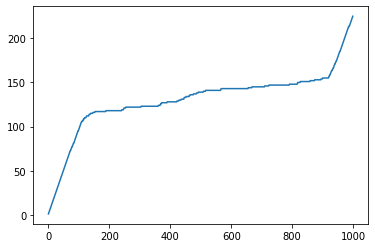

In [6]:
plt.plot(cum_collision_num)

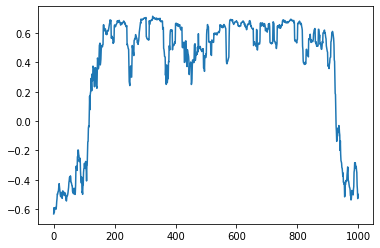

In [7]:
plt.plot(rolling_score)

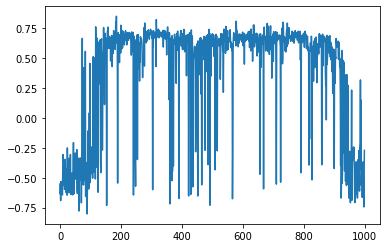

In [8]:
plt.plot(episode_score)

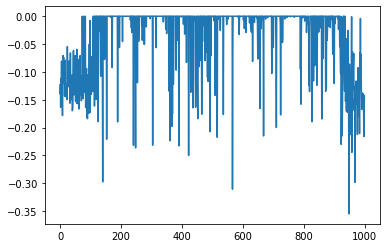

In [9]:
plt.plot(score_safe)

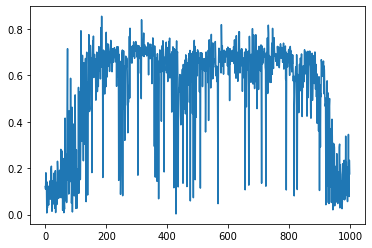

In [10]:
plt.plot(score_efficiency)

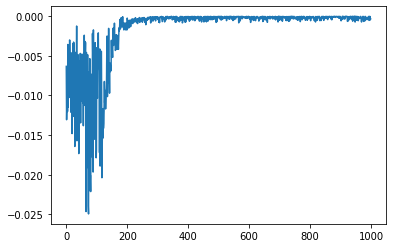

In [11]:
plt.plot(score_comfort)

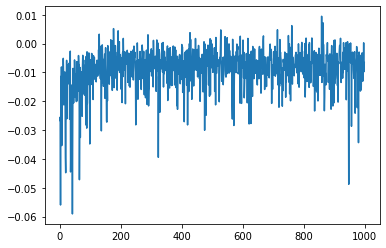

In [12]:
plt.plot(score_energy)